__Author:__ Bram Van de Sande

__Date:__ 7 MAY 2019

__Outline:__ Acquistion and cleaning of selected scRNAseq data sets.

_Experiments:_

| Accession ID | Cancer type | 
| ------------- | ----------- | 
| GSE115978     | SKCM        | 
| GSE103322     | HNSC | 
| E-MTAB-6149/E-MTAB-6653 | LUSC, LUAD |

In [1]:
import os, glob, re
from functools import partial
from collections import OrderedDict

import GEOparse

import pandas as pd
import seaborn as sns
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt

from pyscenic.export import export2loom

/home/bramvds/Documents/miniconda3/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
# Set maximum number of jobs
sc.settings.njobs = 32

TODO:
- Fix bug: default embedding is not loaded properly after uploading?
- Add feature: support for sample id clustering!

In [3]:
import os
import numpy as np
import pandas as pd
import loompy as lp
from sklearn.manifold.t_sne import TSNE
from pyscenic.aucell import aucell
from pyscenic.genesig import Regulon
from typing import List, Mapping, Union, Sequence, Optional
from operator import attrgetter
from multiprocessing import cpu_count
from pyscenic.binarization import binarize
from itertools import chain, repeat, islice
import networkx as nx
import zlib
import base64
import json
from typing import Mapping
from collections import OrderedDict


def compress_encode(value):
    '''
    Compress using ZLIB algorithm and encode the given value in base64.
    Taken from: https://github.com/aertslab/SCopeLoomPy/blob/5438da52c4bcf48f483a1cf378b1eaa788adefcb/src/scopeloompy/utils/__init__.py#L7
    '''
    return base64.b64encode(zlib.compress(value.encode('ascii'))).decode('ascii')


def export2loom(ex_mtx: pd.DataFrame, regulons: List[Regulon], out_fname: str,
                cell_annotations: Optional[Mapping[str,str]]=None,
                tree_structure: Sequence[str] = (),
                title: Optional[str] = None,
                nomenclature: str = "Unknown",
                num_workers: int =cpu_count(),
                embeddings: Mapping[str, pd.DataFrame] = {},
                auc_mtx=None, 
                auc_thresholds=None,
                compress: bool=False):
    """
    Create a loom file for a single cell experiment to be used in SCope.
    :param ex_mtx: The expression matrix (n_cells x n_genes).
    :param regulons: A list of Regulons.
    :param cell_annotations: A dictionary that maps a cell ID to its corresponding cell type annotation.
    :param out_fname: The name of the file to create.
    :param tree_structure: A sequence of strings that defines the category tree structure.
    :param title: The title for this loom file. If None than the basename of the filename is used as the title.
    :param nomenclature: The name of the genome.
    :param num_workers: The number of cores to use for AUCell regulon enrichment.
    :param compress: compress metadata (only when using SCope).
    """
    # Information on the general loom file format: http://linnarssonlab.org/loompy/format/index.html
    # Information on the SCope specific alterations: https://github.com/aertslab/SCope/wiki/Data-Format

    if cell_annotations is None:
        cell_annotations=dict(zip(ex_mtx.index, ['-']*ex_mtx.shape[0]))

    if(regulons[0].name.find(' ')==-1):
        print("Regulon name does not seem to be compatible with SCOPE. It should include a space to allow selection of the TF.",
          "\nPlease run: \n regulons = [r.rename(r.name.replace('(+)',' ('+str(len(r))+'g)')) for r in regulons]",
          "\nor:\n regulons = [r.rename(r.name.replace('(',' (')) for r in regulons]")

    # Calculate regulon enrichment per cell using AUCell.
    if auc_mtx is None:
        auc_mtx = aucell(ex_mtx, regulons, num_workers=num_workers) # (n_cells x n_regulons)
        auc_mtx = auc_mtx.loc[ex_mtx.index]

    # Binarize matrix for AUC thresholds.
    if auc_thresholds is None:
        _, auc_thresholds = binarize(auc_mtx)

    # Create an embedding based on tSNE.
    # Name of columns should be "_X" and "_Y".
    if len(embeddings) == 0:
        embeddings = { "tSNE (default)" : pd.DataFrame(data=TSNE().fit_transform(auc_mtx),
                                      index=ex_mtx.index, columns=['_X', '_Y']) } # (n_cells, 2)
    
    id2name = OrderedDict()
    embeddings_X = pd.DataFrame(index=ex_mtx.index)
    embeddings_Y = pd.DataFrame(index=ex_mtx.index)
    for idx, (name, df_embedding) in enumerate(embeddings.items()):
        if(len(df_embedding.columns)!=2):
            raise Exception('The embedding should have two columns.')
        
        embedding_id = idx - 1 # Default embedding must have id == -1 for SCope.
        id2name[embedding_id] = name
        
        embedding = df_embedding.copy()
        embedding.columns=['_X', '_Y']
        embeddings_X = pd.merge(embeddings_X, embedding['_X'].to_frame().rename(columns={'_X': str(embedding_id)}), left_index=True, right_index=True)
        embeddings_Y = pd.merge(embeddings_Y, embedding['_Y'].to_frame().rename(columns={'_Y': str(embedding_id)}), left_index=True, right_index=True)

    # Calculate the number of genes per cell.
    binary_mtx = ex_mtx.copy()
    binary_mtx[binary_mtx != 0] = 1.0
    ngenes = binary_mtx.sum(axis=1).astype(int)

    # Encode genes in regulons as "binary" membership matrix.
    genes = np.array(ex_mtx.columns)
    n_genes = len(genes)
    n_regulons = len(regulons)
    data = np.zeros(shape=(n_genes, n_regulons), dtype=int)
    for idx, regulon in enumerate(regulons):
        data[:, idx] = np.isin(genes, regulon.genes).astype(int)
    regulon_assignment = pd.DataFrame(data=data,
                                      index=ex_mtx.columns,
                                      columns=list(map(attrgetter('name'), regulons)))

    # Encode cell type clusters.
    # The name of the column should match the identifier of the clustering.
    name2idx = dict(map(reversed, enumerate(sorted(set(cell_annotations.values())))))
    clusterings = pd.DataFrame(data=ex_mtx.index.values,
                               index=ex_mtx.index,
                               columns=['0']).replace(cell_annotations).replace(name2idx)

    # Create meta-data structure.
    def create_structure_array(df):
        # Create a numpy structured array
        return np.array([tuple(row) for row in df.values],
                        dtype=np.dtype(list(zip(df.columns, df.dtypes))))
    
    default_embedding = next(iter(embeddings.values())).copy()
    default_embedding.columns=['_X', '_Y']
    column_attrs = {
        "CellID": ex_mtx.index.values.astype('str'),
        "nGene": ngenes.values,
        "Embedding": create_structure_array(default_embedding),
        "RegulonsAUC": create_structure_array(auc_mtx),
        "Clusterings": create_structure_array(clusterings),
        "ClusterID": clusterings.values,
        'Embeddings_X': create_structure_array(embeddings_X),
        'Embeddings_Y': create_structure_array(embeddings_Y),
        }
    row_attrs = {
        "Gene": ex_mtx.columns.values.astype('str'),
        "Regulons": create_structure_array(regulon_assignment),
        }

    def fetch_logo(context):
        for elem in context:
            if elem.endswith('.png'):
                return elem
        return ""
    name2logo = {reg.name: fetch_logo(reg.context) for reg in regulons}
    regulon_thresholds = [{"regulon": name,
                            "defaultThresholdValue":(threshold if isinstance(threshold, float) else threshold[0]),
                            "defaultThresholdName": "guassian_mixture_split",
                            "allThresholds": {"guassian_mixture_split": (threshold if isinstance(threshold, float) else threshold[0])},
                            "motifData": name2logo.get(name, "")} for name, threshold in auc_thresholds.iteritems()]

    general_attrs = {
        "title": os.path.splitext(os.path.basename(out_fname))[0] if title is None else title,
        "MetaData": json.dumps({
            "embeddings": [{'id': identifier, 'name': name} for identifier, name in id2name.items()],
            "annotations": [{
                "name": "",
                "values": []
            }],
            "clusterings": [{
                "id": 0,
                "group": "celltype",
                "name": "Cell Type",
                "clusters": [{"id": idx, "description": name} for name, idx in name2idx.items()]
            }],
            "regulonThresholds": regulon_thresholds
        }),
        "Genome": nomenclature}

    # Add tree structure.
    # All three levels need to be supplied
    assert len(tree_structure) <= 3, ""
    general_attrs.update(("SCopeTreeL{}".format(idx+1), category)
                         for idx, category in enumerate(list(islice(chain(tree_structure, repeat("")), 3))))

    # Compress MetaData global attribute
    if compress:
        general_attrs["MetaData"] = compress_encode(value=general_attrs["MetaData"])

    # Create loom file for use with the SCope tool.
    # The loom file format opted for rows as genes to facilitate growth along the column axis (i.e add more cells)
    # PySCENIC chose a different orientation because of limitation set by the feather format: selectively reading
    # information from disk can only be achieved via column selection. For the ranking databases this is of utmost
    # importance.
    lp.create(filename=out_fname,
              layers=ex_mtx.T.values,
              row_attrs=row_attrs,
              col_attrs=column_attrs,
              file_attrs=general_attrs)


In [4]:
from pyscenic.binarization import binarize
from pyscenic.genesig import Regulon
from typing import Union, Sequence

def add_scenic_metadata(adata: sc.AnnData, 
               auc_mtx: pd.DataFrame, 
               regulons: Union[None, Sequence[Regulon]] = None,
               bin_rep: bool = False,
               copy: bool = False) -> sc.AnnData:
    """
    Add AUCell values to AnnData object.
    
    :param adata: The AnnData object.
    :param auc_mtx: The dataframe containing the AUCell values (#observations x #regulons).
    :param bin_rep: Also add binarized version of AUCell values as separate representation. This representation
    is stored as `adata.obsm['X_aucell_bin']`.
    :param copy: Return a copy instead of writing to adata.
    :
    """
    assert isinstance(adata, sc.AnnData)
    assert isinstance(auc_mtx, pd.DataFrame)
    assert len(auc_mtx) == adata.n_obs
    
    REGULON_SUFFIX_PATTERN = 'Regulon({})'
    
    result = adata.copy() if copy else adata
    
    # Add AUCell values as new representation (similar to a PCA). This facilitates the usage of
    # AUCell as initial dimensional reduction.
    result.obsm['X_aucell'] = auc_mtx.values.copy()
    if bin_rep:
        bin_mtx, _ = binarize(auc_mtx)
        result.obsm['X_aucell_bin'] = bin_mtx.values
        
    # Encode genes in regulons as "binary" membership matrix.
    if regulons is not None:
        genes = np.array(adata.var_names)
        data = np.zeros(shape=(adata.n_vars, len(regulons)), dtype=bool)
        for idx, regulon in enumerate(regulons):
            data[:, idx] = np.isin(genes, regulon.genes).astype(bool)
        regulon_assignment = pd.DataFrame(data=data, index=genes,
                                          columns=list(map(lambda r: REGULON_SUFFIX_PATTERN.format(r.name), regulons)))
        result.var = pd.merge(result.var, regulon_assignment, left_index=True, right_index=True, how='left')
    
    # Add additional meta-data/information on the regulons.
    def fetch_logo(context):
        for elem in context:
            if elem.endswith('.png'):
                return elem
        return ""
    result.uns['aucell'] = {
        'regulon_names': auc_mtx.columns.map(lambda s: REGULON_SUFFIX_PATTERN.format(s)).values,
        'regulon_motifs': np.array([fetch_logo(reg.context) for reg in regulons] if regulons is not None else []) 
        }
    
    # Add the AUCell values also as annotations of observations. This way regulon activity can be
    # depicted on cellular scatterplots.
    mtx = auc_mtx.copy()
    mtx.columns = result.uns['aucell']['regulon_names']
    result.obs = pd.merge(result.obs, mtx, left_index=True, right_index=True, how='left')
    
    return result

# GSE115978 - Cutaneous Melanoma (SKCM)

_Publication:_

A Cancer Cell Program Promotes T Cell Exclusion and Resistance to Checkpoint Blockade.

Livnat Jerby-Arnon, Parin Shah, Michael S Cuoco, Christopher Rodman, Mei-Ju Su, Johannes C Melms, Rachel Leeson, Abhay Kanodia, Shaolin Mei, Jia-Ren Lin, Shu Wang, Bokang Rabasha, David Liu, Gao Zhang, Claire Margolais, Orr Ashenberg, Patrick A Ott, Elizabeth I Buchbinder, Rizwan Haq, F Stephen Hodi, Genevieve M Boland, Ryan J Sullivan, Dennie T Frederick, Benchun Miao, Tabea Moll, Keith T Flaherty, Meenhard Herlyn, Russell W Jenkins, Rohit Thummalapalli, Monika S Kowalczyk, Israel Cañadas, Bastian Schilling, Adam N R Cartwright, Adrienne M Luoma, Shruti Malu, Patrick Hwu, Chantale Bernatchez, Marie-Andrée Forget, David A Barbie, Alex K Shalek, Itay Tirosh, Peter K Sorger, Kai Wucherpfennig, Eliezer M Van Allen, Dirk Schadendorf, Bruce E Johnson, Asaf Rotem, Orit Rozenblatt-Rosen, Levi A Garraway, Charles H Yoon, Benjamin Izar, Aviv Regev

Immune checkpoint inhibitors (ICIs) produce durable responses in some melanoma patients, but many patients derive no clinical benefit, and the molecular underpinnings of such resistance remain elusive. Here, we leveraged single-cell RNA sequencing (scRNA-seq) from 33 melanoma tumors and computational analyses to interrogate malignant cell states that promote immune evasion. We identified a resistance program expressed by malignant cells that is associated with T cell exclusion and immune evasion. The program is expressed prior to immunotherapy, characterizes cold niches in situ, and predicts clinical responses to anti-PD-1 therapy in an independent cohort of 112 melanoma patients. CDK4/6-inhibition represses this program in individual malignant cells, induces senescence, and reduces melanoma tumor outgrowth in mouse models in vivo when given in combination with immunotherapy. Our study provides a high-resolution landscape of ICI-resistant cell states, identifies clinically predictive signatures, and suggests new therapeutic strategies to overcome immunotherapy resistance.

Cell 2018

https://dx.doi.org/10.1016/j.cell.2018.09.006


_Data set acquisition:_

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE115978

_Remarks:_
1. This data set includes samples from previous study (Itay Tirosh et al.).
2. One sample, i.e. Mel75, was analyzed in this previous study as well as in this subsequent study.
3. Codes:

| Code | Description |
| ---- | ----------- |
| OR | Objective Response |
| ICI | Immune Checkpoint Inhibitor |

In [5]:
BASE_FOLDER = "/home/bramvds/Documents/datasets/GSE115978"
# Downloaded from GEO on 28 FEB 2019.
CELL_ANNOTATIONS_FNAME = os.path.join(BASE_FOLDER, "GSE115978_cell.annotations.csv")
# Downloaded from Cell Journal website on 1 MAR 2019.
SAMPLE_METADATA_FNAME = os.path.join(BASE_FOLDER, "1-s2.0-S0092867418311784-mmc1.xlsx")

EXP_MTX_TPM_FNAME = os.path.join(BASE_FOLDER, 'GSE115978.tpm.csv')
EXP_MTX_COUNTS_FNAME = os.path.join(BASE_FOLDER, 'GSE115978.counts.csv')
METADATA_FNAME = os.path.join(BASE_FOLDER, 'GSE115978.metadata.csv')
SCORES_MTX_FNAME = os.path.join(BASE_FOLDER, 'GSE115978.msigdb.scores.csv')
ANNDATA_FNAME = os.path.join(BASE_FOLDER, 'GSE115978.msigdb.h5ad')

AUCELL_MTX_FNAME = '/home/bramvds/Documents/scenic_resources/{}.auc.csv'.format('GSE115978')
REGULONS_DAT_FNAME = '/home/bramvds/Documents/scenic_resources/{}.regulons.dat'.format('GSE115978')

LOOM_FNAME = os.path.join(BASE_FOLDER, 'SKCM_GSE115978.loom')

__METADATA CLEANING__

In [6]:
df_annotations = pd.read_csv(CELL_ANNOTATIONS_FNAME)
df_annotations['samples'] = df_annotations['samples'].str.upper()
df_annotations.rename(columns={'cell.types': 'cell_type', 'cells': 'cell_id', 'samples': 'sample_id', 
                               'treatment.group': 'treatment_group', 'Cohort': 'cohort'}, inplace=True)
df_annotations['cell_type'] = df_annotations.cell_type.replace({
    'Mal': 'Malignant Cell',
    'Endo.': 'Endothelial Cell',
    'T.CD4': 'Thelper Cell',
    'CAF': 'Fibroblast',
    'T.CD8': 'Tcytotoxic Cell',
    'T.cell': 'T Cell',
    'NK': 'NK Cell',
    'B.cell': 'B Cell'})

In [7]:
df_samples = pd.read_excel(SAMPLE_METADATA_FNAME, header=2)
df_samples = df_samples.drop(['Cohort'], axis=1)
df_samples['Sample'] = df_samples.Sample.str.upper()

In [8]:
df_metadata = pd.merge(df_annotations, df_samples, left_on='sample_id', right_on='Sample')
df_metadata = df_metadata.drop(['Sample', 'treatment_group'], axis=1)
df_metadata.rename(columns={'Patient': 'patient_id',
                           'Age': 'age', 'Sex': 'sex', 'Lesion type': 'lesion_type', 'Site': 'site',
                           'Treatment': 'treatment', 'Treatment group': 'treatment_group'}, inplace=True)

In [9]:
df_metadata.head()

cell_id sample_id       cell_type  cohort  \
0  cy78_CD45_neg_1_B04_S496_comb     MEL78  Malignant Cell  Tirosh   
1  cy78_CD45_neg_3_H06_S762_comb     MEL78  Malignant Cell  Tirosh   
2  cy78_CD45_neg_1_D07_S523_comb     MEL78  Malignant Cell  Tirosh   
3  cy78_CD45_neg_3_D01_S709_comb     MEL78  Malignant Cell  Tirosh   
4  cy78_CD45_neg_2_B08_S596_comb     MEL78  Malignant Cell  Tirosh   

   no.of.genes  no.of.reads patient_id  age sex  \
0         8258       357919      Mel78   73   M   
1         7409       380341      Mel78   73   M   
2         8548       394632      Mel78   73   M   
3         8472       425938      Mel78   73   M   
4         6475        70466      Mel78   73   M   

                        treatment       treatment_group lesion_type  \
0  WDVAX, ipilimumab + nivolumab   Post-ICI (resistant)  metastasis   
1  WDVAX, ipilimumab + nivolumab   Post-ICI (resistant)  metastasis   
2  WDVAX, ipilimumab + nivolumab   Post-ICI (resistant)  metastasis   
3  WDVAX, ipilimumab + nivolumab   Post-ICI (resistant)  metastasis   
4  WDVAX, ipilimumab + nivolumab   Post-ICI (resistant)  metastasis   

           site  
0  Small bowel   
1  Small bowel   
2  Small bowel   
3  Small bowel   
4  Small bowel

In [10]:
df_metadata.to_csv(METADATA_FNAME, index=False)

In [11]:
df_metadata.columns

Index(['cell_id', 'sample_id', 'cell_type', 'cohort', 'no.of.genes',
       'no.of.reads', 'patient_id', 'age', 'sex', 'treatment',
       'treatment_group', 'lesion_type', 'site'],
      dtype='object')

__EXPRESSION MATRIX__

In [12]:
df_tpm = pd.read_csv(EXP_MTX_TPM_FNAME, index_col=0)
df_tpm.shape

(23686, 7186)

In [13]:
#df_counts = pd.read_csv(EXP_MTX_COUNTS_FNAME, index_col=0)
#df_counts.shape

__ANNDATA__

ssGSEA scores for MSigDB signatures http://software.broadinstitute.org/gsea/msigdb/index.jsp cannot be stored on disk because this exceeds the available metadata on disk via the HDF5 format (64kb limit).

In [14]:
df_obs = df_metadata[['cell_id', 'sample_id', 'cell_type', 'cohort', 'patient_id', 'age', 'sex', 'treatment',
                                                           'treatment_group', 'lesion_type', 'site']].set_index('cell_id').sort_index()

In [15]:
adata = sc.AnnData(X=df_tpm.T.sort_index())
adata.obs = df_obs
adata.var_names_make_unique()
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.raw = adata #Store non-log transformed data as raw. This data can be used via the use_raw parameters available for many functions.
sc.pp.log1p(adata)
adata

AnnData object with n_obs × n_vars = 7186 × 22527 
    obs: 'sample_id', 'cell_type', 'cohort', 'patient_id', 'age', 'sex', 'treatment', 'treatment_group', 'lesion_type', 'site', 'n_genes'
    var: 'n_cells'

In [16]:
adata.write_h5ad(ANNDATA_FNAME)

... storing 'sample_id' as categorical
... storing 'cell_type' as categorical
... storing 'cohort' as categorical
... storing 'patient_id' as categorical
... storing 'sex' as categorical
... storing 'treatment' as categorical
... storing 'treatment_group' as categorical
... storing 'lesion_type' as categorical
... storing 'site' as categorical


__ADD DIMENSIONAL REDUCTIONS__

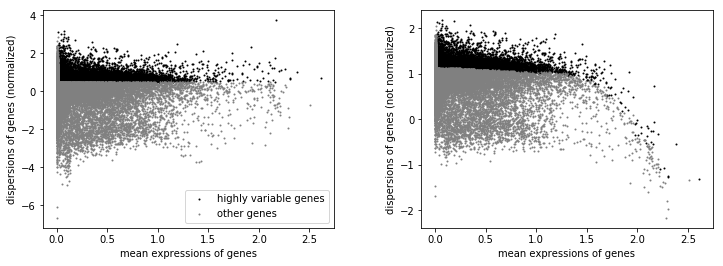

In [17]:
sc.pp.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata)

In [18]:
adata.var['highly_variable']['GREM1']

True

In [19]:
#adata = adata[:, adata.var['highly_variable']]

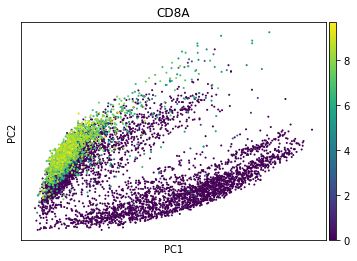

In [20]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CD8A')

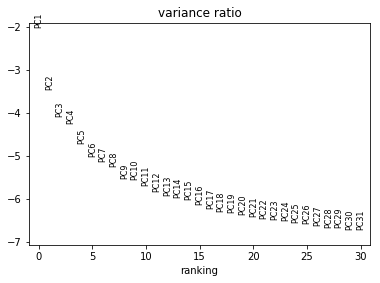

In [21]:
sc.pl.pca_variance_ratio(adata, log=True)

In [22]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.tsne(adata)
sc.tl.louvain(adata)

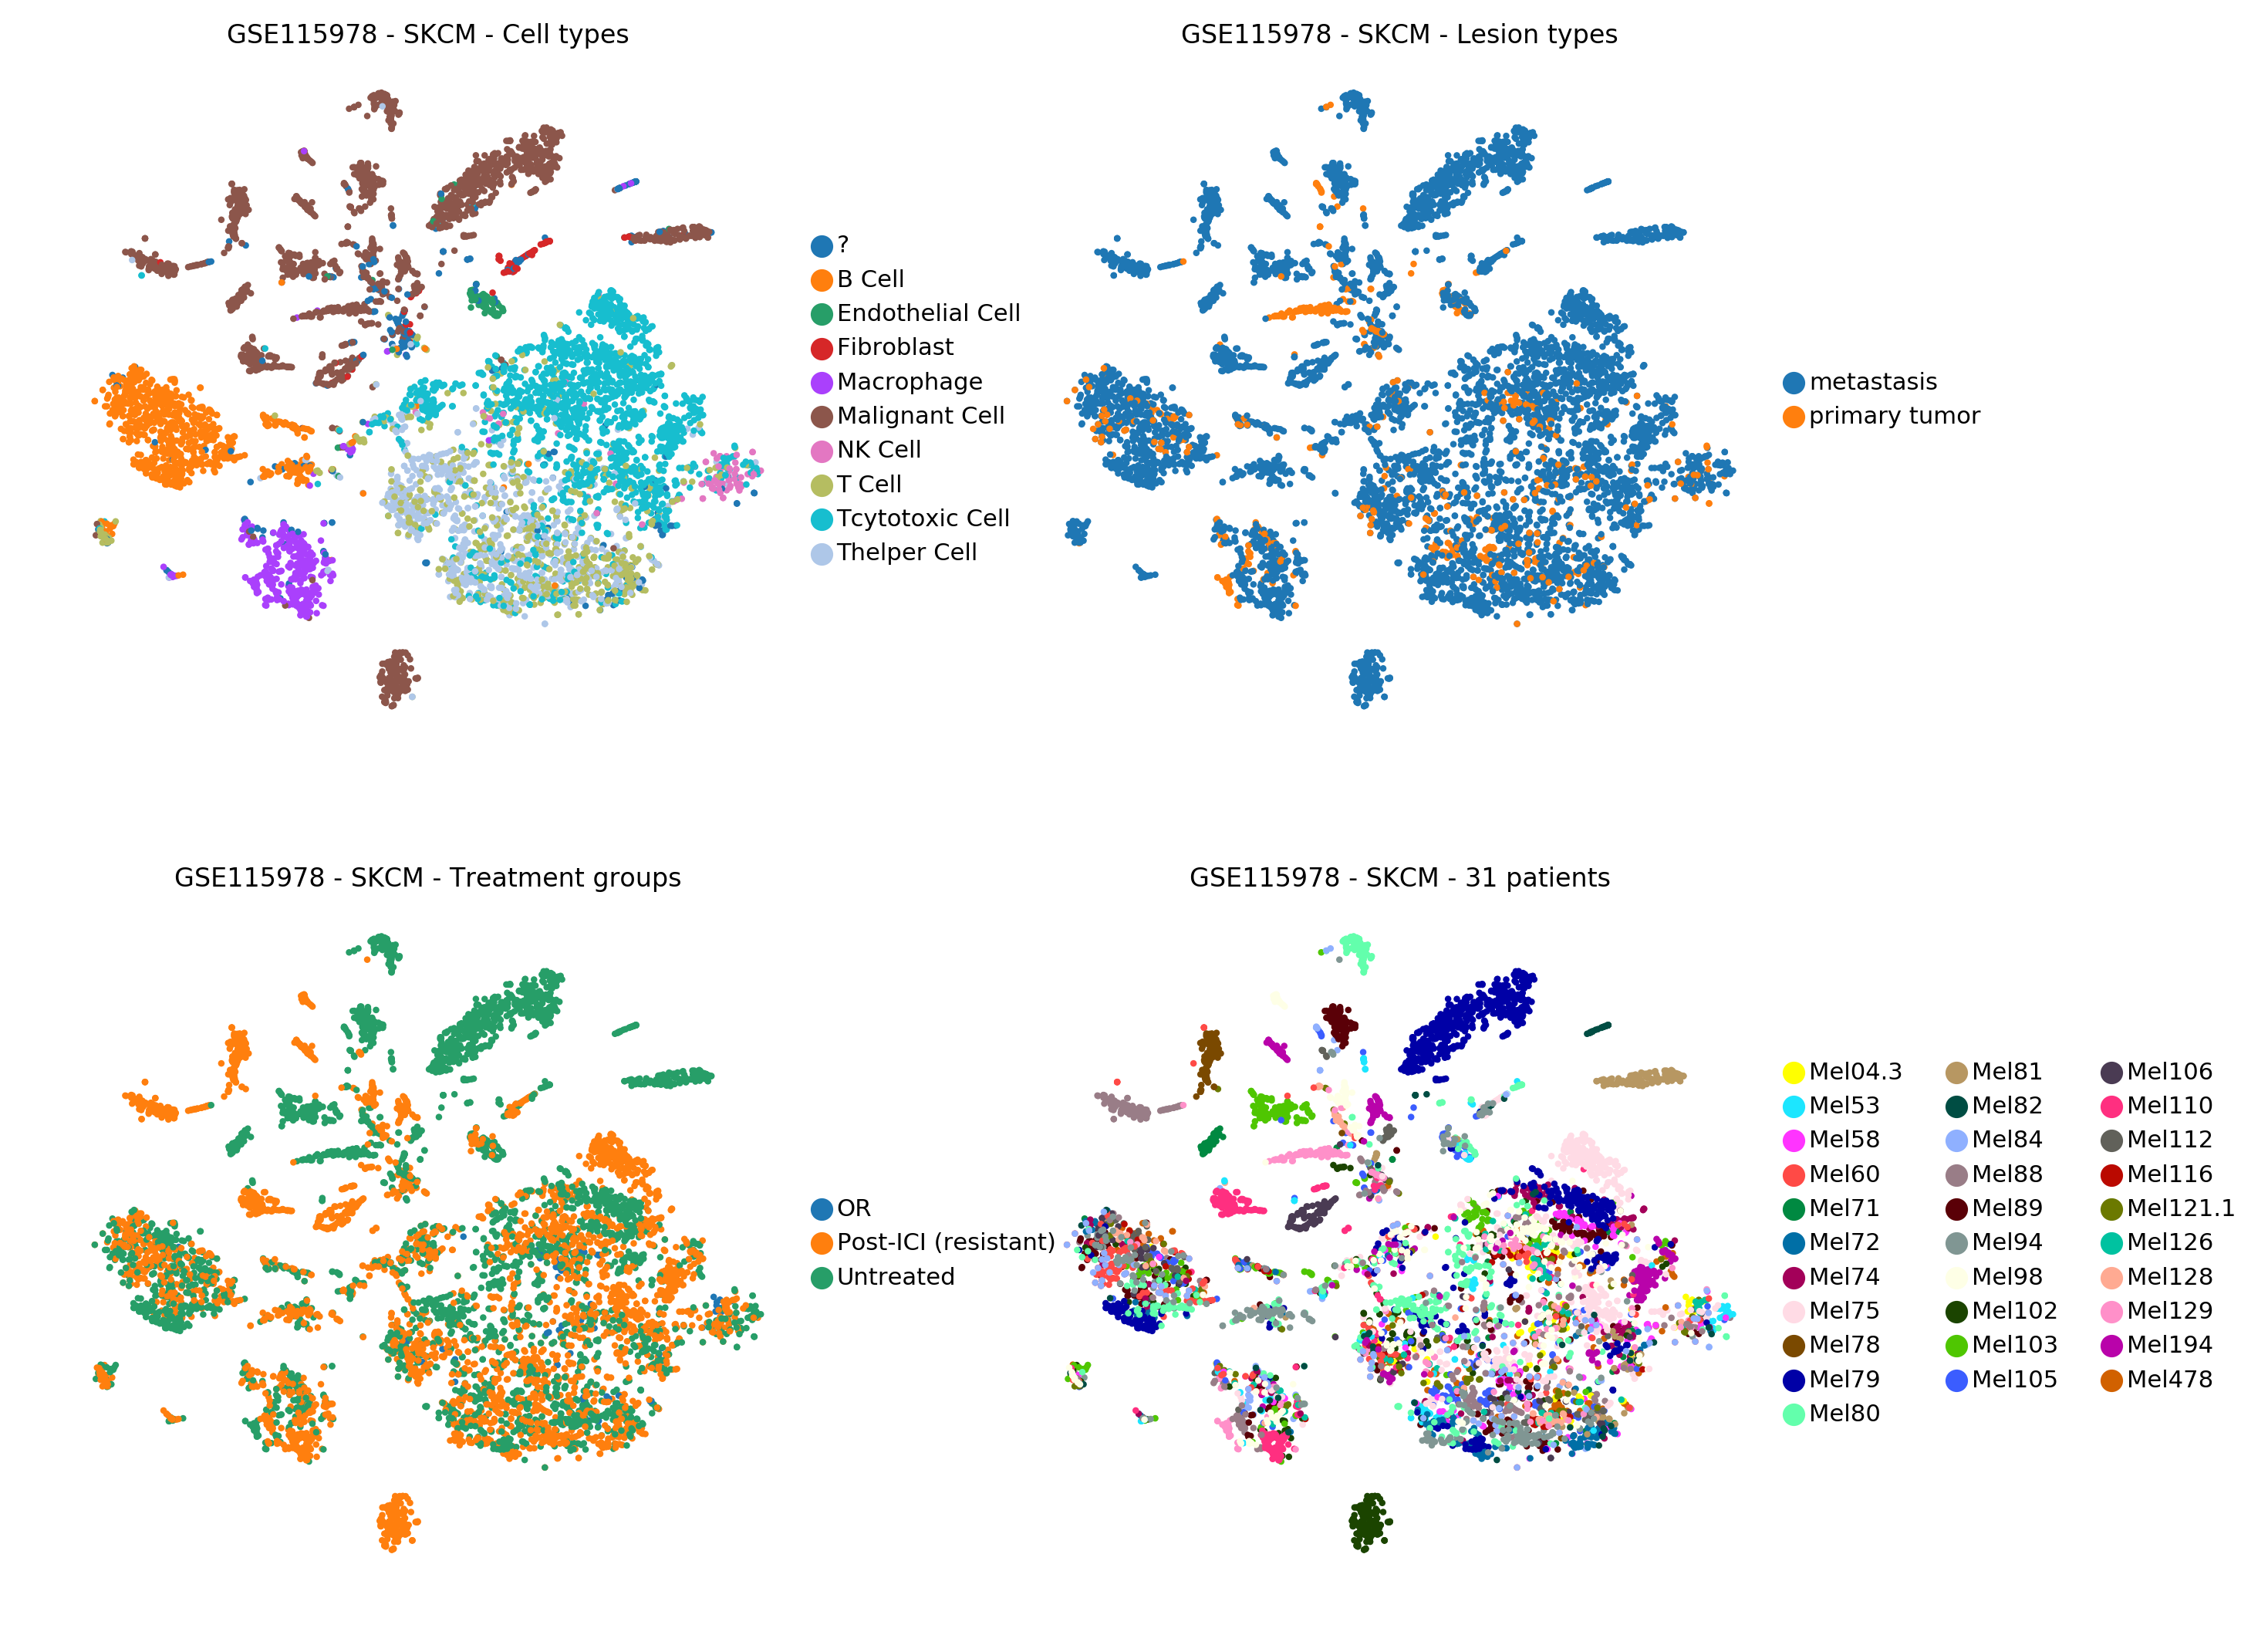

In [23]:
sc.set_figure_params(frameon=False, dpi=150, fontsize=8)
sc.pl.tsne(adata, color=['cell_type', 'lesion_type', 'treatment_group', 'patient_id'], 
           title=['GSE115978 - SKCM - Cell types', 'GSE115978 - SKCM - Lesion types', 'GSE115978 - SKCM - Treatment groups',
                 'GSE115978 - SKCM - {} patients'.format(len(adata.obs.patient_id.unique()))], ncols=2)

In [24]:
adata.write_h5ad(ANNDATA_FNAME)

In [25]:
embedding_pca_tsne = pd.DataFrame(adata.obsm['X_tsne'], columns=[['_X', '_Y']], index=adata.obs_names)

In [26]:
import pickle

auc_mtx = pd.read_csv(AUCELL_MTX_FNAME, index_col=0)
with open(REGULONS_DAT_FNAME, 'rb') as f:
    regulons = pickle.load(f)
add_scenic_metadata(adata, auc_mtx, regulons)
adata.write_h5ad(ANNDATA_FNAME)

In [27]:
sc.tl.tsne(adata, use_rep='X_aucell')

In [28]:
embedding_aucell_tsne = pd.DataFrame(adata.obsm['X_tsne'], columns=[['_X', '_Y']], index=adata.obs_names)

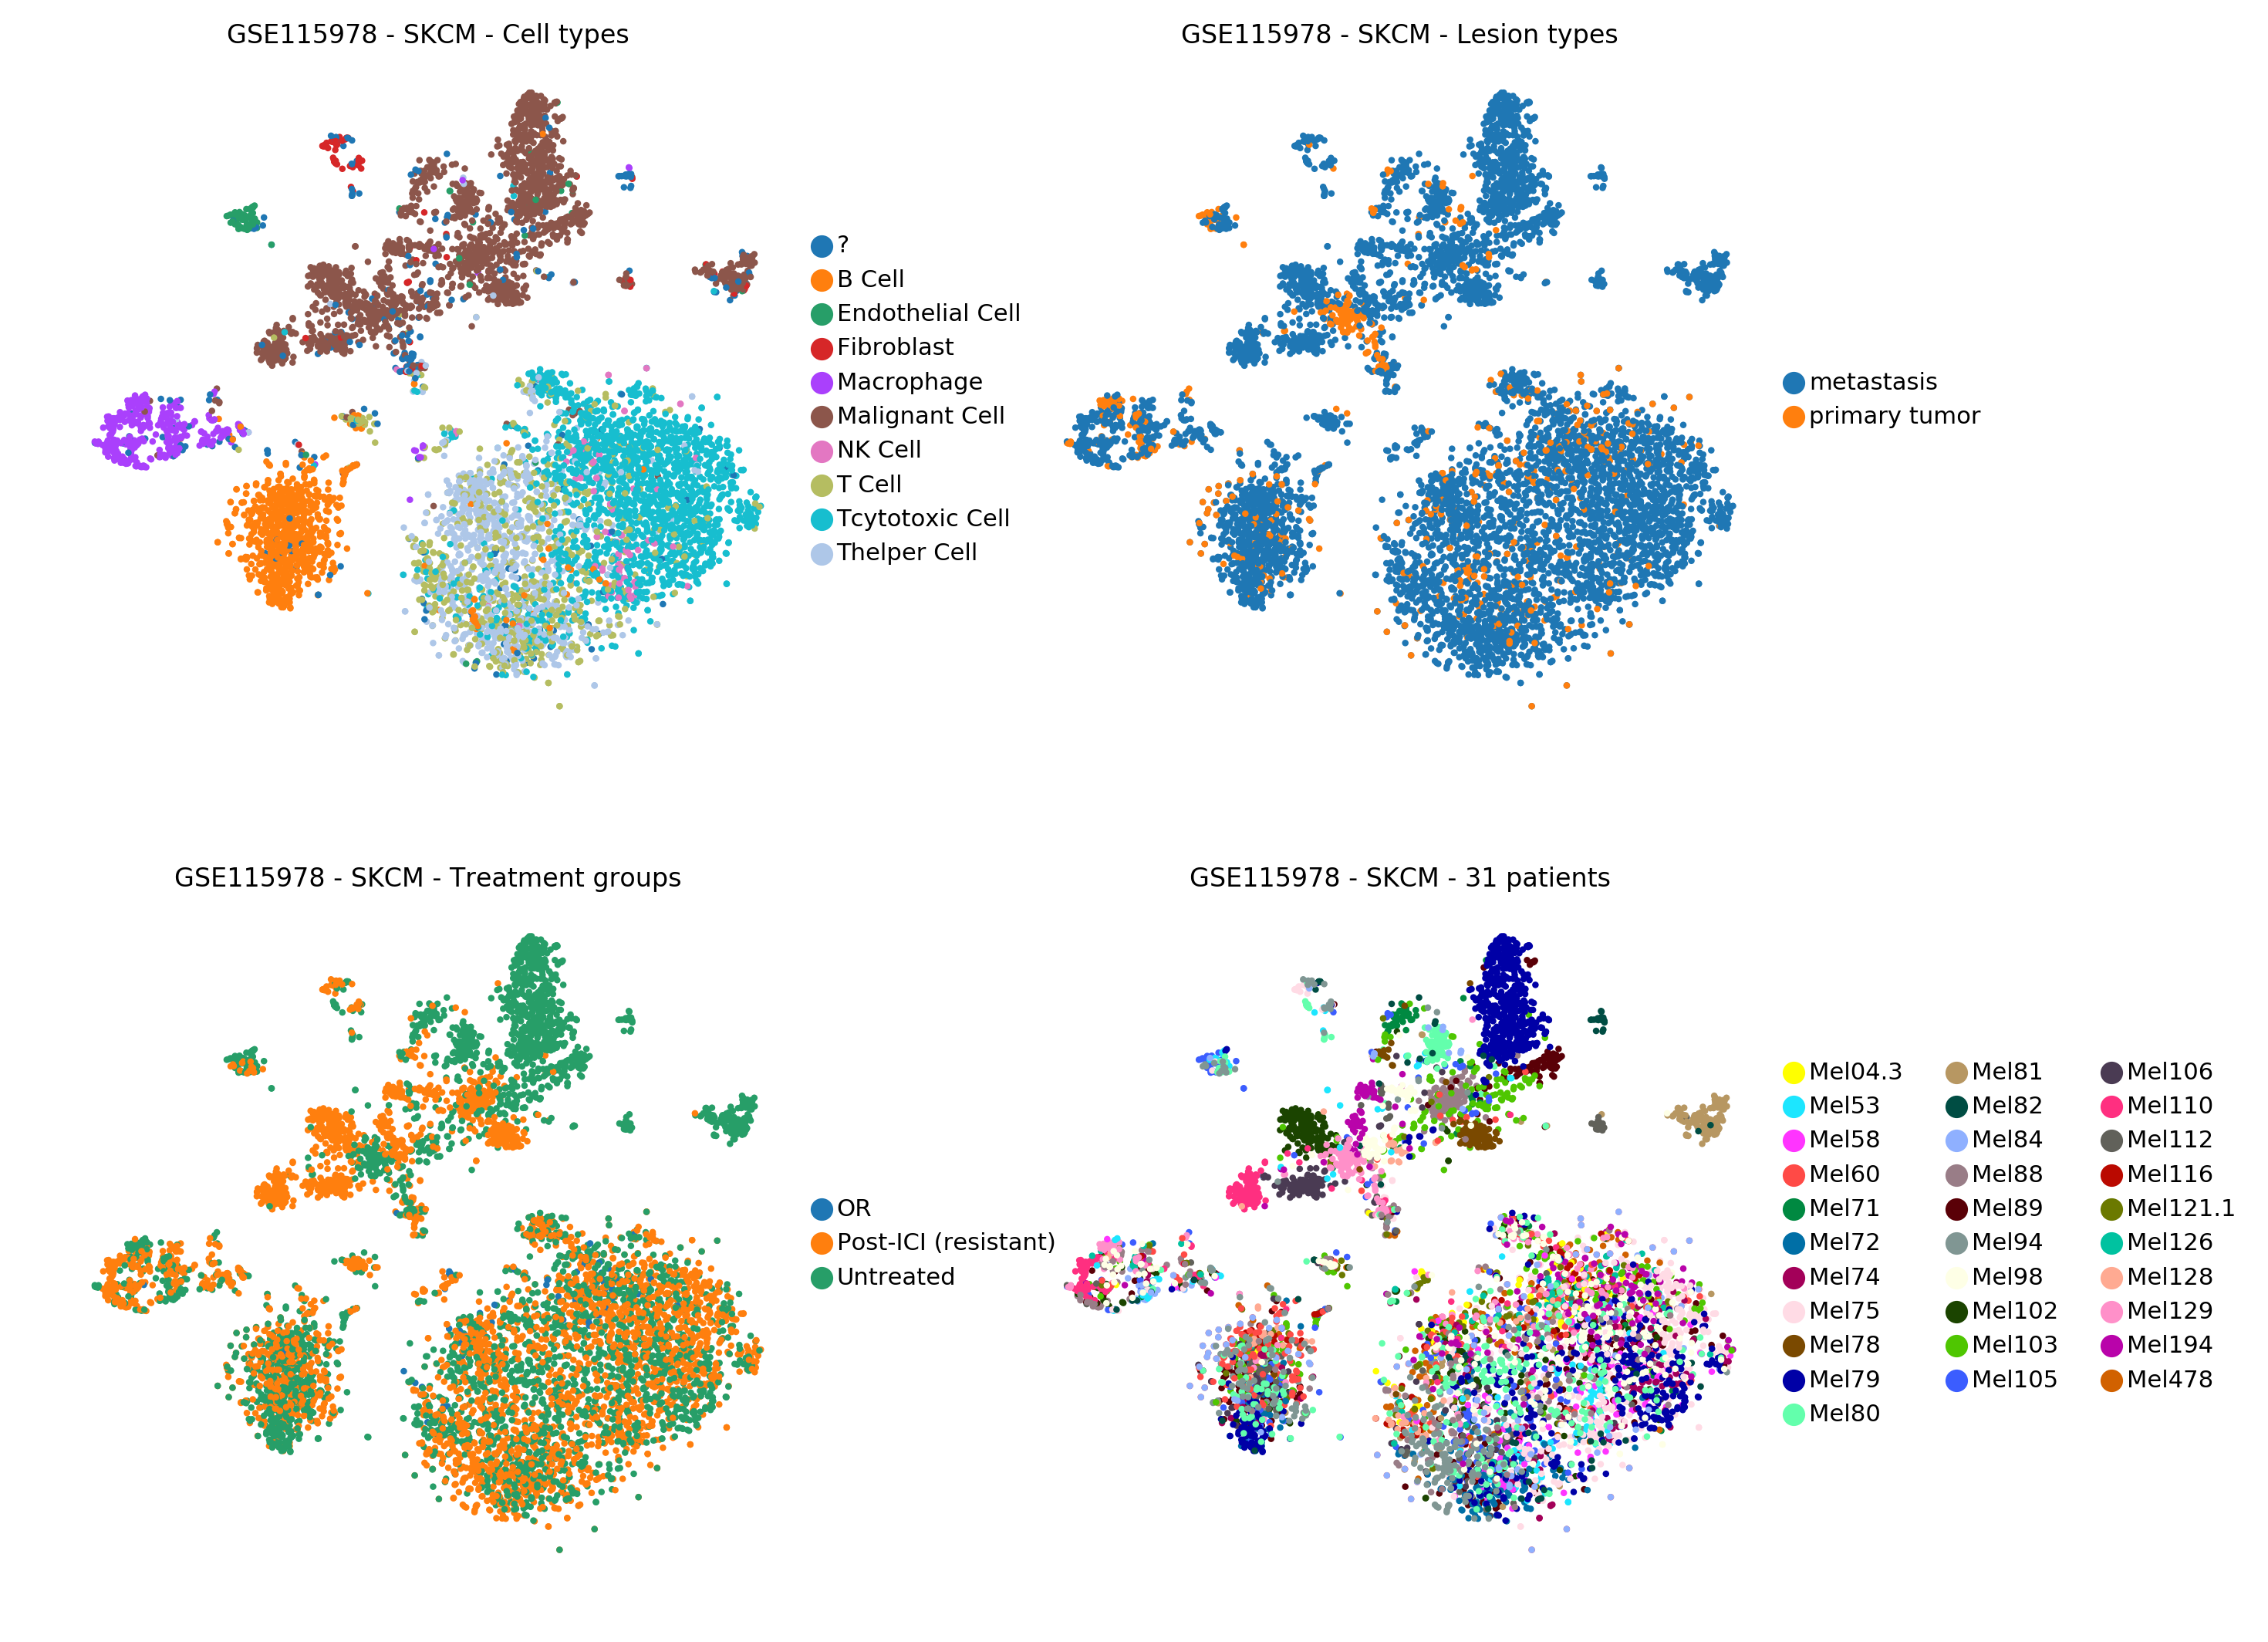

In [29]:
sc.set_figure_params(frameon=False, dpi=150, fontsize=8)
sc.pl.tsne(adata, color=['cell_type', 'lesion_type', 'treatment_group', 'patient_id'], 
           title=['GSE115978 - SKCM - Cell types', 'GSE115978 - SKCM - Lesion types', 'GSE115978 - SKCM - Treatment groups',
                 'GSE115978 - SKCM - {} patients'.format(len(adata.obs.patient_id.unique()))], ncols=2)

In [31]:
export2loom(adata.to_df(), regulons, LOOM_FNAME,
            cell_annotations=adata.obs['cell_type'].to_dict(),
            embeddings=OrderedDict([('AUCell + tSNE', embedding_aucell_tsne), ('PCA + tSNE', embedding_pca_tsne)]),
            auc_mtx = auc_mtx,
            tree_structure=(),
            title='SKCM_GSE115978',
            nomenclature="HGNC", 
            compress=True)

Regulon name does not seem to be compatible with SCOPE. It should include a space to allow selection of the TF. 
Please run: 
 regulons = [r.rename(r.name.replace('(+)',' ('+str(len(r))+'g)')) for r in regulons] 
or:
 regulons = [r.rename(r.name.replace('(',' (')) for r in regulons]


# GSE103322 - Head and Neck Squamous Cell Carcinoma (HNSC)

_Publication:_

Single-Cell Transcriptomic Analysis of Primary and Metastatic Tumor Ecosystems in Head and Neck Cancer

Sidharth V Puram, Itay Tirosh, Anuraag S Parikh, Anoop P Patel, Keren Yizhak, Shawn Gillespie, Christopher Rodman, Christina L Luo, Edmund A Mroz, Kevin S Emerick, Daniel G Deschler, Mark A Varvares, Ravi Mylvaganam, Orit Rozenblatt-Rosen, James W Rocco, William C Faquin, Derrick T Lin, Aviv Regev, Bradley E Bernstein

The diverse malignant, stromal, and immune cells in tumors affect growth, metastasis, and response to therapy. We profiled transcriptomes of ∼6,000 single cells from 18 head and neck squamous cell carcinoma (HNSCC) patients, including five matched pairs of primary tumors and lymph node metastases. Stromal and immune cells had consistent expression programs across patients. Conversely, malignant cells varied within and between tumors in their expression of signatures related to cell cycle, stress, hypoxia, epithelial differentiation, and partial epithelial-to-mesenchymal transition (p-EMT). Cells expressing the p-EMT program spatially localized to the leading edge of primary tumors. By integrating single-cell transcriptomes with bulk expression profiles for hundreds of tumors, we refined HNSCC subtypes by their malignant and stromal composition and established p-EMT as an independent predictor of nodal metastasis, grade, and adverse pathologic features. Our results provide insight into the HNSCC ecosystem and define stromal interactions and a p-EMT program associated with metastasis.

Cell 2017

https://dx.doi.org/10.1016/j.cell.2017.10.044

_Data set acquisition:_

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE103322


In [32]:
GEO_ACCESSION = "GSE103322"
BASE_FOLDER = "/home/bramvds/Documents/datasets"
DATASET_FOLDER = os.path.join(BASE_FOLDER, GEO_ACCESSION)
MTX_FNAME = os.path.join(DATASET_FOLDER, '{}.tpm.csv'.format(GEO_ACCESSION))
ANNOT_FNAME = os.path.join(DATASET_FOLDER, '{}.annotations.csv'.format(GEO_ACCESSION))
METADATA_FNAME = os.path.join(DATASET_FOLDER, '{}.metadata.csv'.format(GEO_ACCESSION))
SCORES_MTX_FNAME = os.path.join(DATASET_FOLDER, '{}.msigdb.scores.csv'.format(GEO_ACCESSION))
ANNDATA_FNAME = os.path.join(DATASET_FOLDER, '{}.msigdb.h5ad'.format(GEO_ACCESSION))
AUCELL_MTX_FNAME = '/home/bramvds/Documents/scenic_resources/{}.auc.csv'.format(GEO_ACCESSION)
REGULONS_DAT_FNAME = '/home/bramvds/Documents/scenic_resources/{}.regulons.dat'.format(GEO_ACCESSION)

LOOM_FNAME = os.path.join(DATASET_FOLDER, 'HNSC_{}.loom'.format(GEO_ACCESSION))

__EXPRESSION MATRIX__

In [33]:
def process_gse103322(fname):
    # Load CSV file
    mtx = pd.read_csv(os.path.join(DATASET_FOLDER, fname), sep='\t', index_col=0, skiprows=[1,2,3,4,5])
    
    # Extract gene symbol
    mtx.index = list(map(lambda g: g[1:-1], mtx.index))
    
    # Remove duplicate gene symbols (keep last when sorted ascending order according to row sum)
    mtx = mtx.iloc[mtx.sum(axis=1).argsort()]
    mtx = mtx[~mtx.index.duplicated(keep='last')]
    
    return mtx

In [34]:
mtx = process_gse103322('GSE103322_HNSCC_all_data.txt')

In [35]:
mtx.head()

HN28_P15_D06_S330_comb  HN28_P6_G05_S173_comb  \
MIR3529                        0.0                    0.0   
SNORD113-9                     0.0                    0.0   
MAGEB16                        0.0                    0.0   
MIR4633                        0.0                    0.0   
SNORA49                        0.0                    0.0   

            HN26_P14_D11_S239_comb  HN26_P14_H05_S281_comb  \
MIR3529                        0.0                     0.0   
SNORD113-9                     0.0                     0.0   
MAGEB16                        0.0                     0.0   
MIR4633                        0.0                     0.0   
SNORA49                        0.0                     0.0   

            HN26_P25_H09_S189_comb  HN26_P14_H06_S282_comb  \
MIR3529                        0.0                     0.0   
SNORD113-9                     0.0                     0.0   
MAGEB16                        0.0                     0.0   
MIR4633                        0.0                     0.0   
SNORA49                        0.0                     0.0   

            HN25_P25_C04_S316_comb  HN26_P25_A11_S107_comb  \
MIR3529                        0.0                     0.0   
SNORD113-9                     0.0                     0.0   
MAGEB16                        0.0                     0.0   
MIR4633                        0.0                     0.0   
SNORA49                        0.0                     0.0   

            HN26_P25_C09_S129_comb  HNSCC26_P24_H05_S377_comb  \
MIR3529                        0.0                        0.0   
SNORD113-9                     0.0                        0.0   
MAGEB16                        0.0                        0.0   
MIR4633                        0.0                        0.0   
SNORA49                        0.0                        0.0   

                     ...             HNSCC20_P3_B10_S22_comb  \
MIR3529              ...                                 0.0   
SNORD113-9           ...                                 0.0   
MAGEB16              ...                                 0.0   
MIR4633              ...                                 0.0   
SNORA49              ...                                 0.0   

            HNSCC20_P13_B11_S215_comb  HNSCC20_P3_C08_S32_comb  \
MIR3529                           0.0                      0.0   
SNORD113-9                        0.0                      0.0   
MAGEB16                           0.0                      0.0   
MIR4633                           0.0                      0.0   
SNORA49                           0.0                      0.0   

            HNSCC17_P4_H03_S183_comb  HNSCC20_P3_F09_S69_comb  \
MIR3529                          0.0                      0.0   
SNORD113-9                       0.0                      0.0   
MAGEB16                          0.0                      0.0   
MIR4633                          0.0                      0.0   
SNORA49                          0.0                      0.0   

            HNSCC17_P4_G12_S180_comb  HNSCC20_P13_C05_S221_comb  \
MIR3529                          0.0                        0.0   
SNORD113-9                       0.0                        0.0   
MAGEB16                          0.0                        0.0   
MIR4633                          0.0                        0.0   
SNORA49                          0.0                        0.0   

            HNSCC17_P4_C12_S132_comb  HNSCC20_P3_H08_S92_comb  \
MIR3529                          0.0                      0.0   
SNORD113-9                       0.0                      0.0   
MAGEB16                          0.0                      0.0   
MIR4633                          0.0                      0.0   
SNORA49                          0.0                      0.0   

            HNSCC20_P3_G06_S78_comb  
MIR3529                         0.0  
SNORD113-9                      0.0  
MAGEB16                         0.0  
MIR4633         

In [36]:
mtx.to_csv(MTX_FNAME, index=True)

__METADATA CLEANING__

In [37]:
cell_annotations = pd.read_csv(os.path.join(DATASET_FOLDER, 'GSE103322_HNSCC_all_data.txt'), sep='\t', index_col=0, low_memory=False).head(5)

In [38]:
cell_annotations

HN28_P15_D06_S330_comb HN28_P6_G05_S173_comb  \
processed by Maxima enzyme                          1                     1   
Lymph node                                          1                     0   
classified  as cancer cell                          0                     0   
classified as non-cancer cells                      1                     1   
non-cancer cell type                       Fibroblast            Fibroblast   

                                HN26_P14_D11_S239_comb HN26_P14_H05_S281_comb  \
processed by Maxima enzyme                         1.0                      1   
Lymph node                                         1.0                      1   
classified  as cancer cell                         1.0                      0   
classified as non-cancer cells                     0.0                      1   
non-cancer cell type                               0.0             Fibroblast   

                                HN26_P25_H09_S189_comb  \
processed by Maxima enzyme                         1.0   
Lymph node                                         1.0   
classified  as cancer cell                         1.0   
classified as non-cancer cells                     0.0   
non-cancer cell type                               0.0   

                                HN26_P14_H06_S282_comb  \
processed by Maxima enzyme                         1.0   
Lymph node                                         1.0   
classified  as cancer cell                         1.0   
classified as non-cancer cells                     0.0   
non-cancer cell type                               0.0   

                                HN25_P25_C04_S316_comb HN26_P25_A11_S107_comb  \
processed by Maxima enzyme                         1.0                      1   
Lymph node                                         1.0                      1   
classified  as cancer cell                         1.0                      0   
classified as non-cancer cells                     0.0                      1   
non-cancer cell type                               0.0             Fibroblast   

                                HN26_P25_C09_S129_comb  \
processed by Maxima enzyme                         1.0   
Lymph node                                         1.0   
classified  as cancer cell                         1.0   
classified as non-cancer cells                     0.0   
non-cancer cell type                               0.0   

                                HNSCC26_P24_H05_S377_comb  \
processed by Maxima enzyme                            1.0   
Lymph node                                            1.0   
classified  as cancer cell                            1.0   
classified as non-cancer cells                        0.0   
non-cancer cell type                                  0.0   

                                         ...             \
processed by Maxima enzyme               ...              
Lymph node                               ...              
classified  as cancer cell               ...              
classified as non-cancer cells           ...              
non-cancer cell type                     ...              

                               HNSCC20_P3_B10_S22_comb  \
processed by Maxima enzyme                         0.0   
Lymph node                                         0.0   
classified  as cancer cell                         1.0   
classified as non-cancer cells                     0.0   
non-cancer cell type                               0.0   

                                HNSCC20_P13_B11_S215_comb  \
processed by Maxima enzyme                            0.0   
Lymph node                                            1.0   
classified  as cancer cell                            1.0   
classified as non-cancer cells                        0.0   
non-cancer cell type                                  0.0   

                               HNSCC20_P3_C08_S32_comb  \
processed by Maxima enzyme             

In [39]:
cell_type = pd.Series(data=list(map(lambda t: t[0] if t[1] else 'Malignant Cell',
                                    zip(cell_annotations.T['non-cancer cell type'], 
                                        cell_annotations.T['classified as non-cancer cells'].map(float).map(bool)))),
                      index = cell_annotations.columns, name='cell_type').replace({'-Fibroblast': 'Fibroblast',
                  'myocyte': 'Myocyte',
                  'Endothelial': 'Endothelial Cell',
                  'Dendritic': 'Dendritic Cell',
                  'Mast': 'Mast Cell',
                  'T cell': 'T Cell',
                  'B cell': 'B Cell'})

In [40]:
lesion_type = pd.Series(data=list(map(lambda t: 'Lymph node' if t else 'Primary tumor',
                                    cell_annotations.T['Lymph node'].map(float).map(bool))),
                      index = cell_annotations.columns, name='lesion_type')

In [41]:
def clean_pid(s: str) -> str:
    m = re.match("HN(SCC)?_?(\d{1,2})_", s)
    if m:
        return 'MEEI{}'.format(int(m.group(2)))
    else:
        return 'MEEI9'

In [42]:
cell_annotations.columns.map(clean_pid).value_counts().sort_index()

MEEI10     89
MEEI12    157
MEEI13     90
MEEI16    596
MEEI17    663
MEEI18    567
MEEI20    691
MEEI22    201
MEEI23     51
MEEI24    130
MEEI25    725
MEEI26    428
MEEI28    616
MEEI5     370
MEEI6     308
MEEI7       7
MEEI8     104
MEEI9     109
dtype: int64

In [43]:
patient_id = pd.Series(data=cell_annotations.columns.map(clean_pid), index = cell_annotations.columns, name='patient_id')

In [44]:
df_metadata = pd.concat([cell_type, lesion_type, patient_id], axis=1).reset_index().rename(columns={'index': 'cell_id'})

In [45]:
df_metadata.to_csv(ANNOT_FNAME, sep=',')

__ANNDATA__

In [46]:
df_obs = df_metadata.set_index('cell_id').sort_index()

In [47]:
adata = sc.AnnData(X=mtx.T.sort_index())
adata.obs = df_obs
adata.var_names_make_unique()
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.raw = adata #Store non-log transformed data as raw. This data can be used via the use_raw parameters available for many functions.
sc.pp.log1p(adata)
adata

AnnData object with n_obs × n_vars = 5902 × 21519 
    obs: 'cell_type', 'lesion_type', 'patient_id', 'n_genes'
    var: 'n_cells'

In [48]:
adata.write_h5ad(ANNDATA_FNAME)

... storing 'cell_type' as categorical
... storing 'lesion_type' as categorical
... storing 'patient_id' as categorical


__ADD DIMENSIONAL REDUCTIONS__

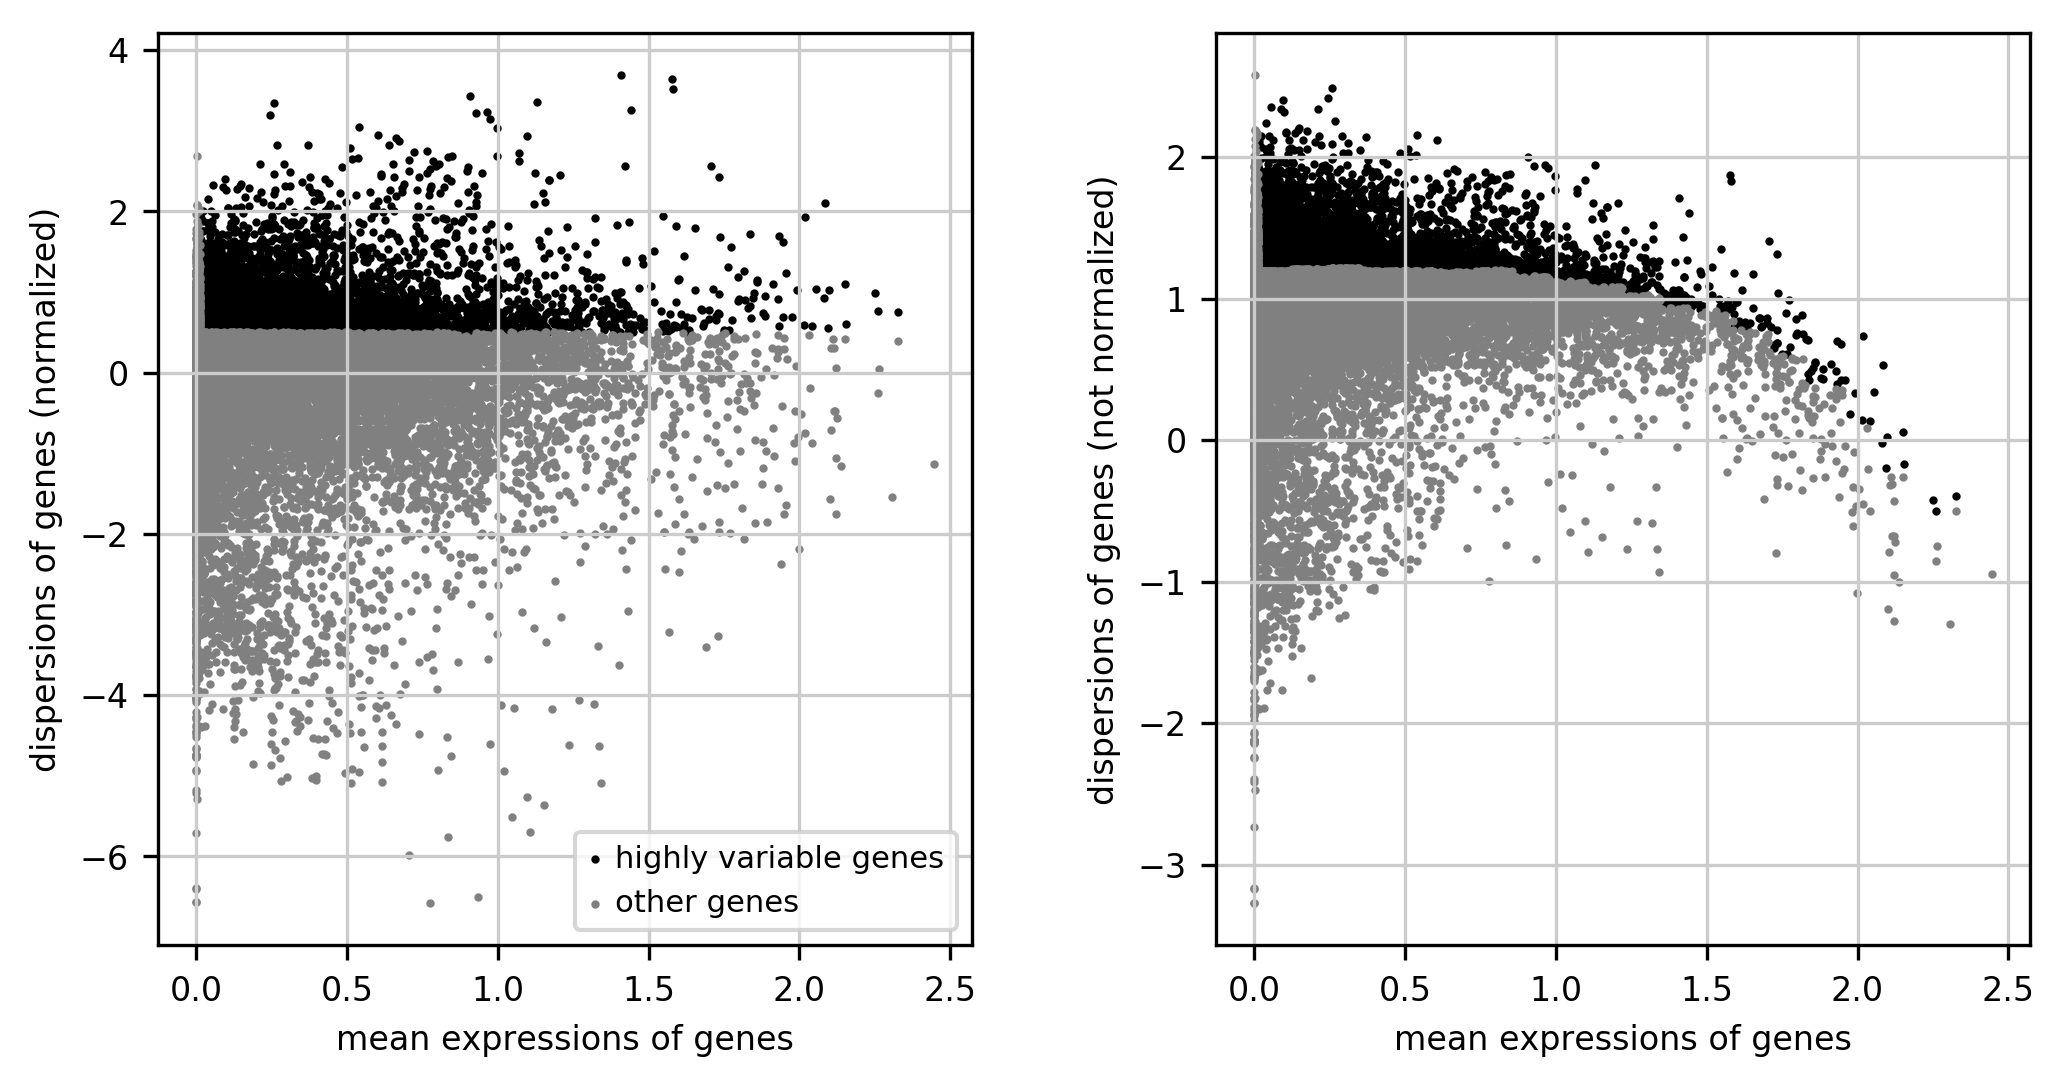

In [49]:
sc.pp.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata)

In [1]:
sc.tl.pca(adata, svd_solver='arpack')

NameError: name 'sc' is not defined

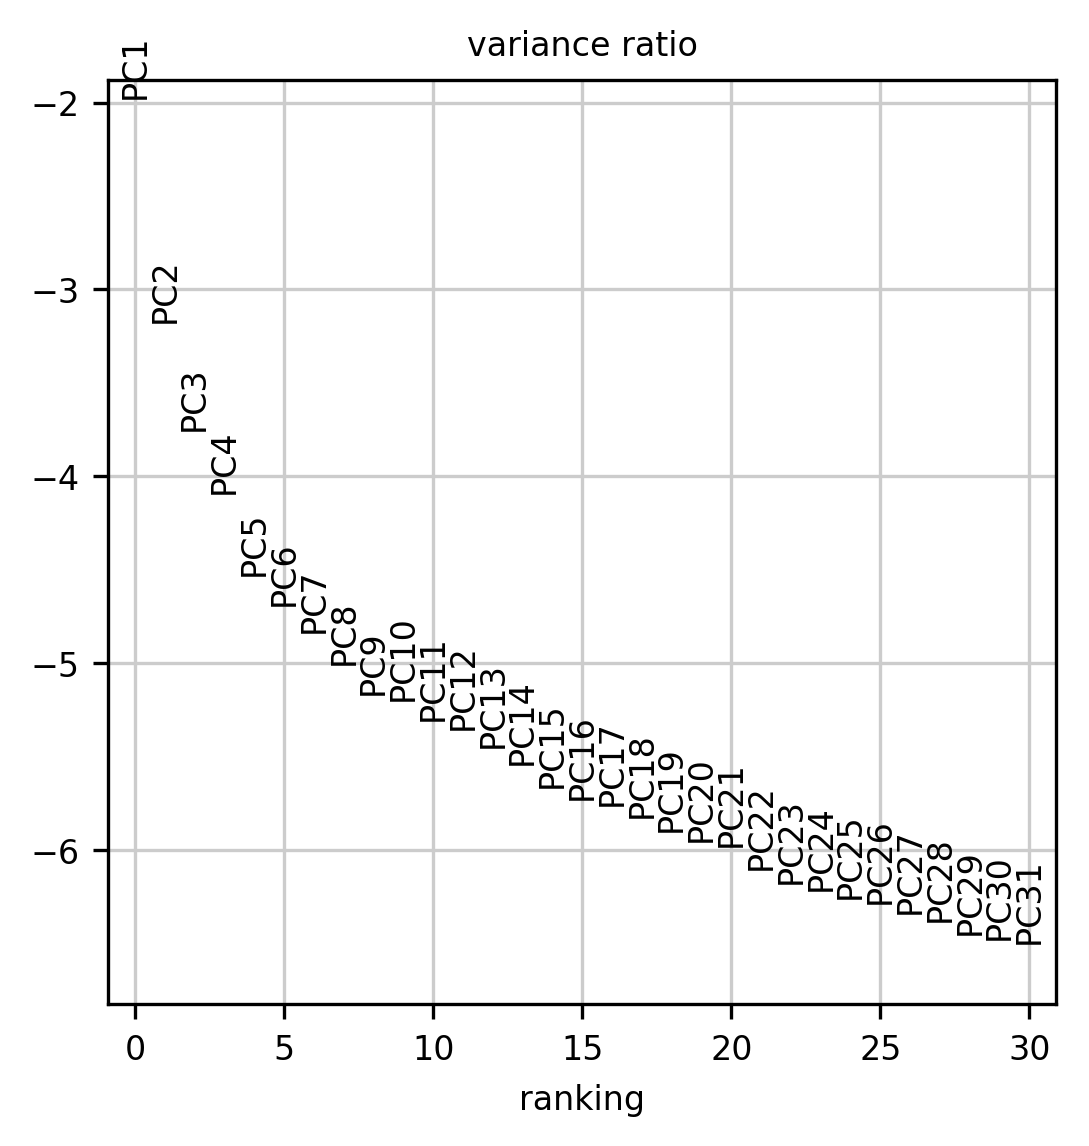

In [52]:
sc.pl.pca_variance_ratio(adata, log=True)

In [53]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.tsne(adata)
sc.tl.louvain(adata)

In [54]:
adata.write_h5ad(ANNDATA_FNAME)

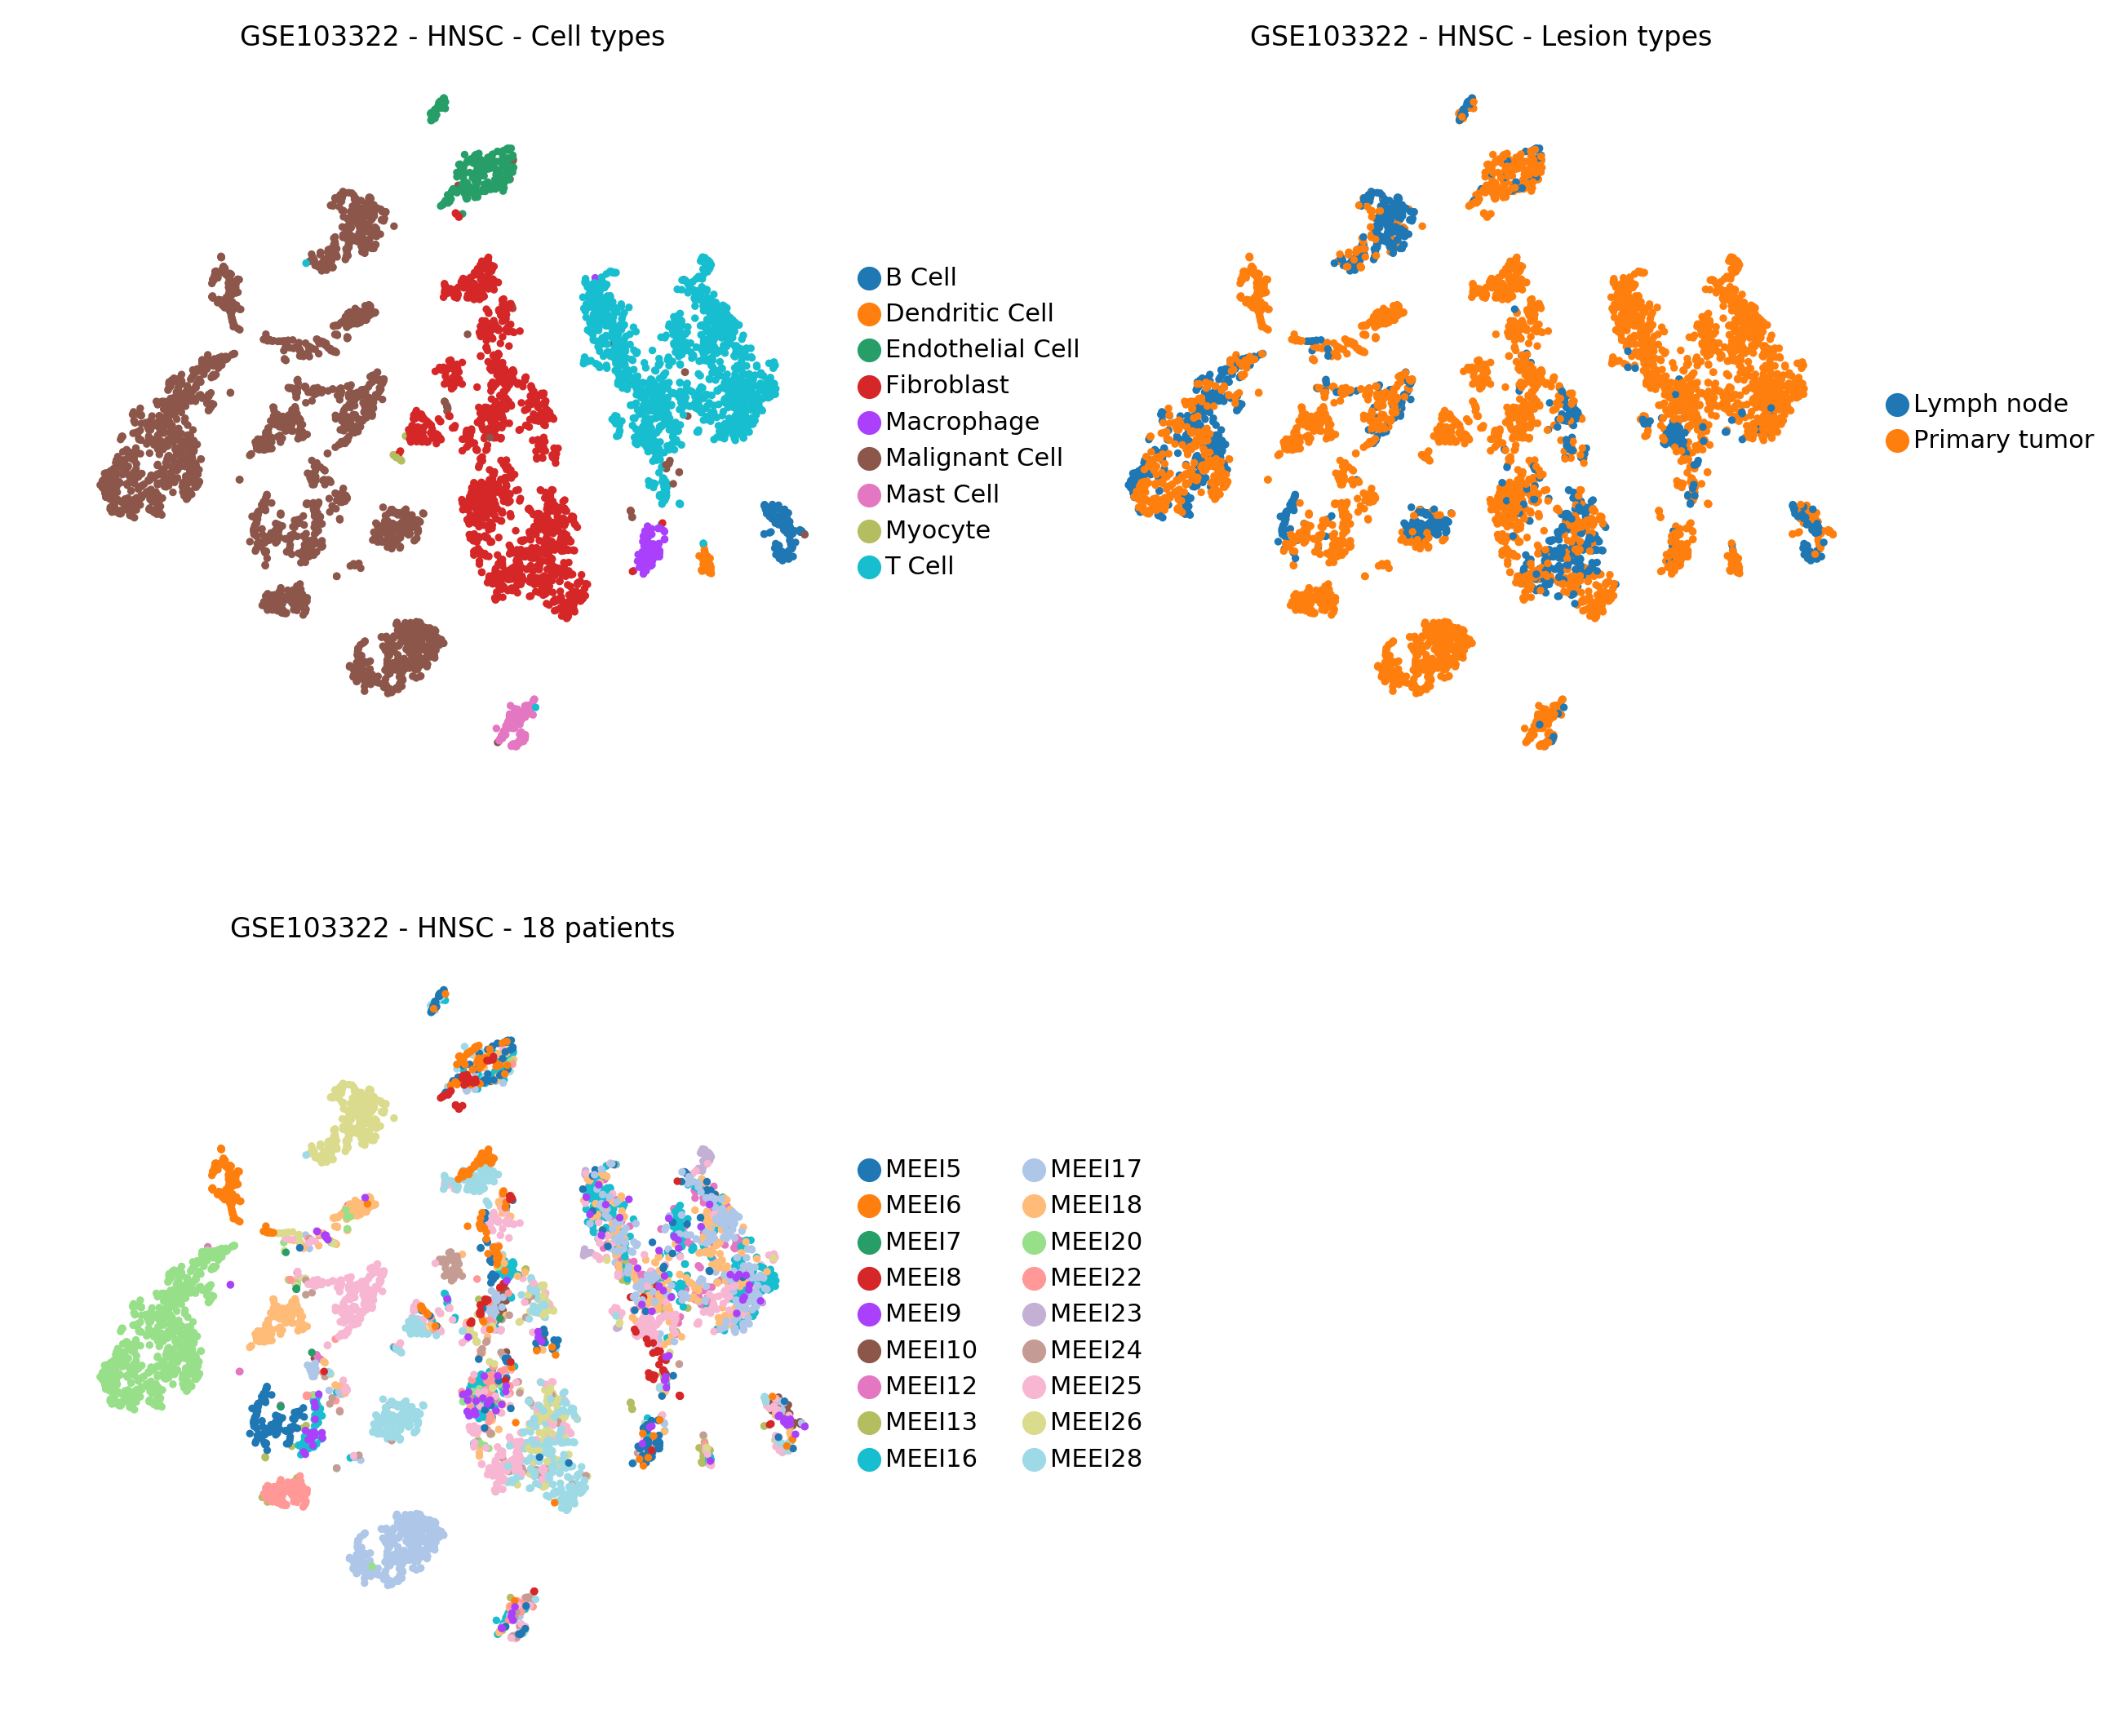

In [55]:
sc.set_figure_params(frameon=False, dpi=150, fontsize=8)
sc.pl.tsne(adata, color=['cell_type', 'lesion_type','patient_id'], 
           title=['GSE103322 - HNSC - Cell types', 'GSE103322 - HNSC - Lesion types',
                 'GSE103322 - HNSC - {} patients'.format(len(adata.obs.patient_id.unique()))], ncols=2)

In [56]:
embedding_pca_tsne = pd.DataFrame(adata.obsm['X_tsne'], columns=[['_X', '_Y']], index=adata.obs_names)

In [57]:
import pickle

auc_mtx = pd.read_csv(AUCELL_MTX_FNAME, index_col=0)
with open(REGULONS_DAT_FNAME, 'rb') as f:
    regulons = pickle.load(f)
add_scenic_metadata(adata, auc_mtx, regulons)
adata.write_h5ad(ANNDATA_FNAME)

In [58]:
sc.tl.tsne(adata, use_rep='X_aucell')

In [59]:
embedding_aucell_tsne = pd.DataFrame(adata.obsm['X_tsne'], columns=[['_X', '_Y']], index=adata.obs_names)

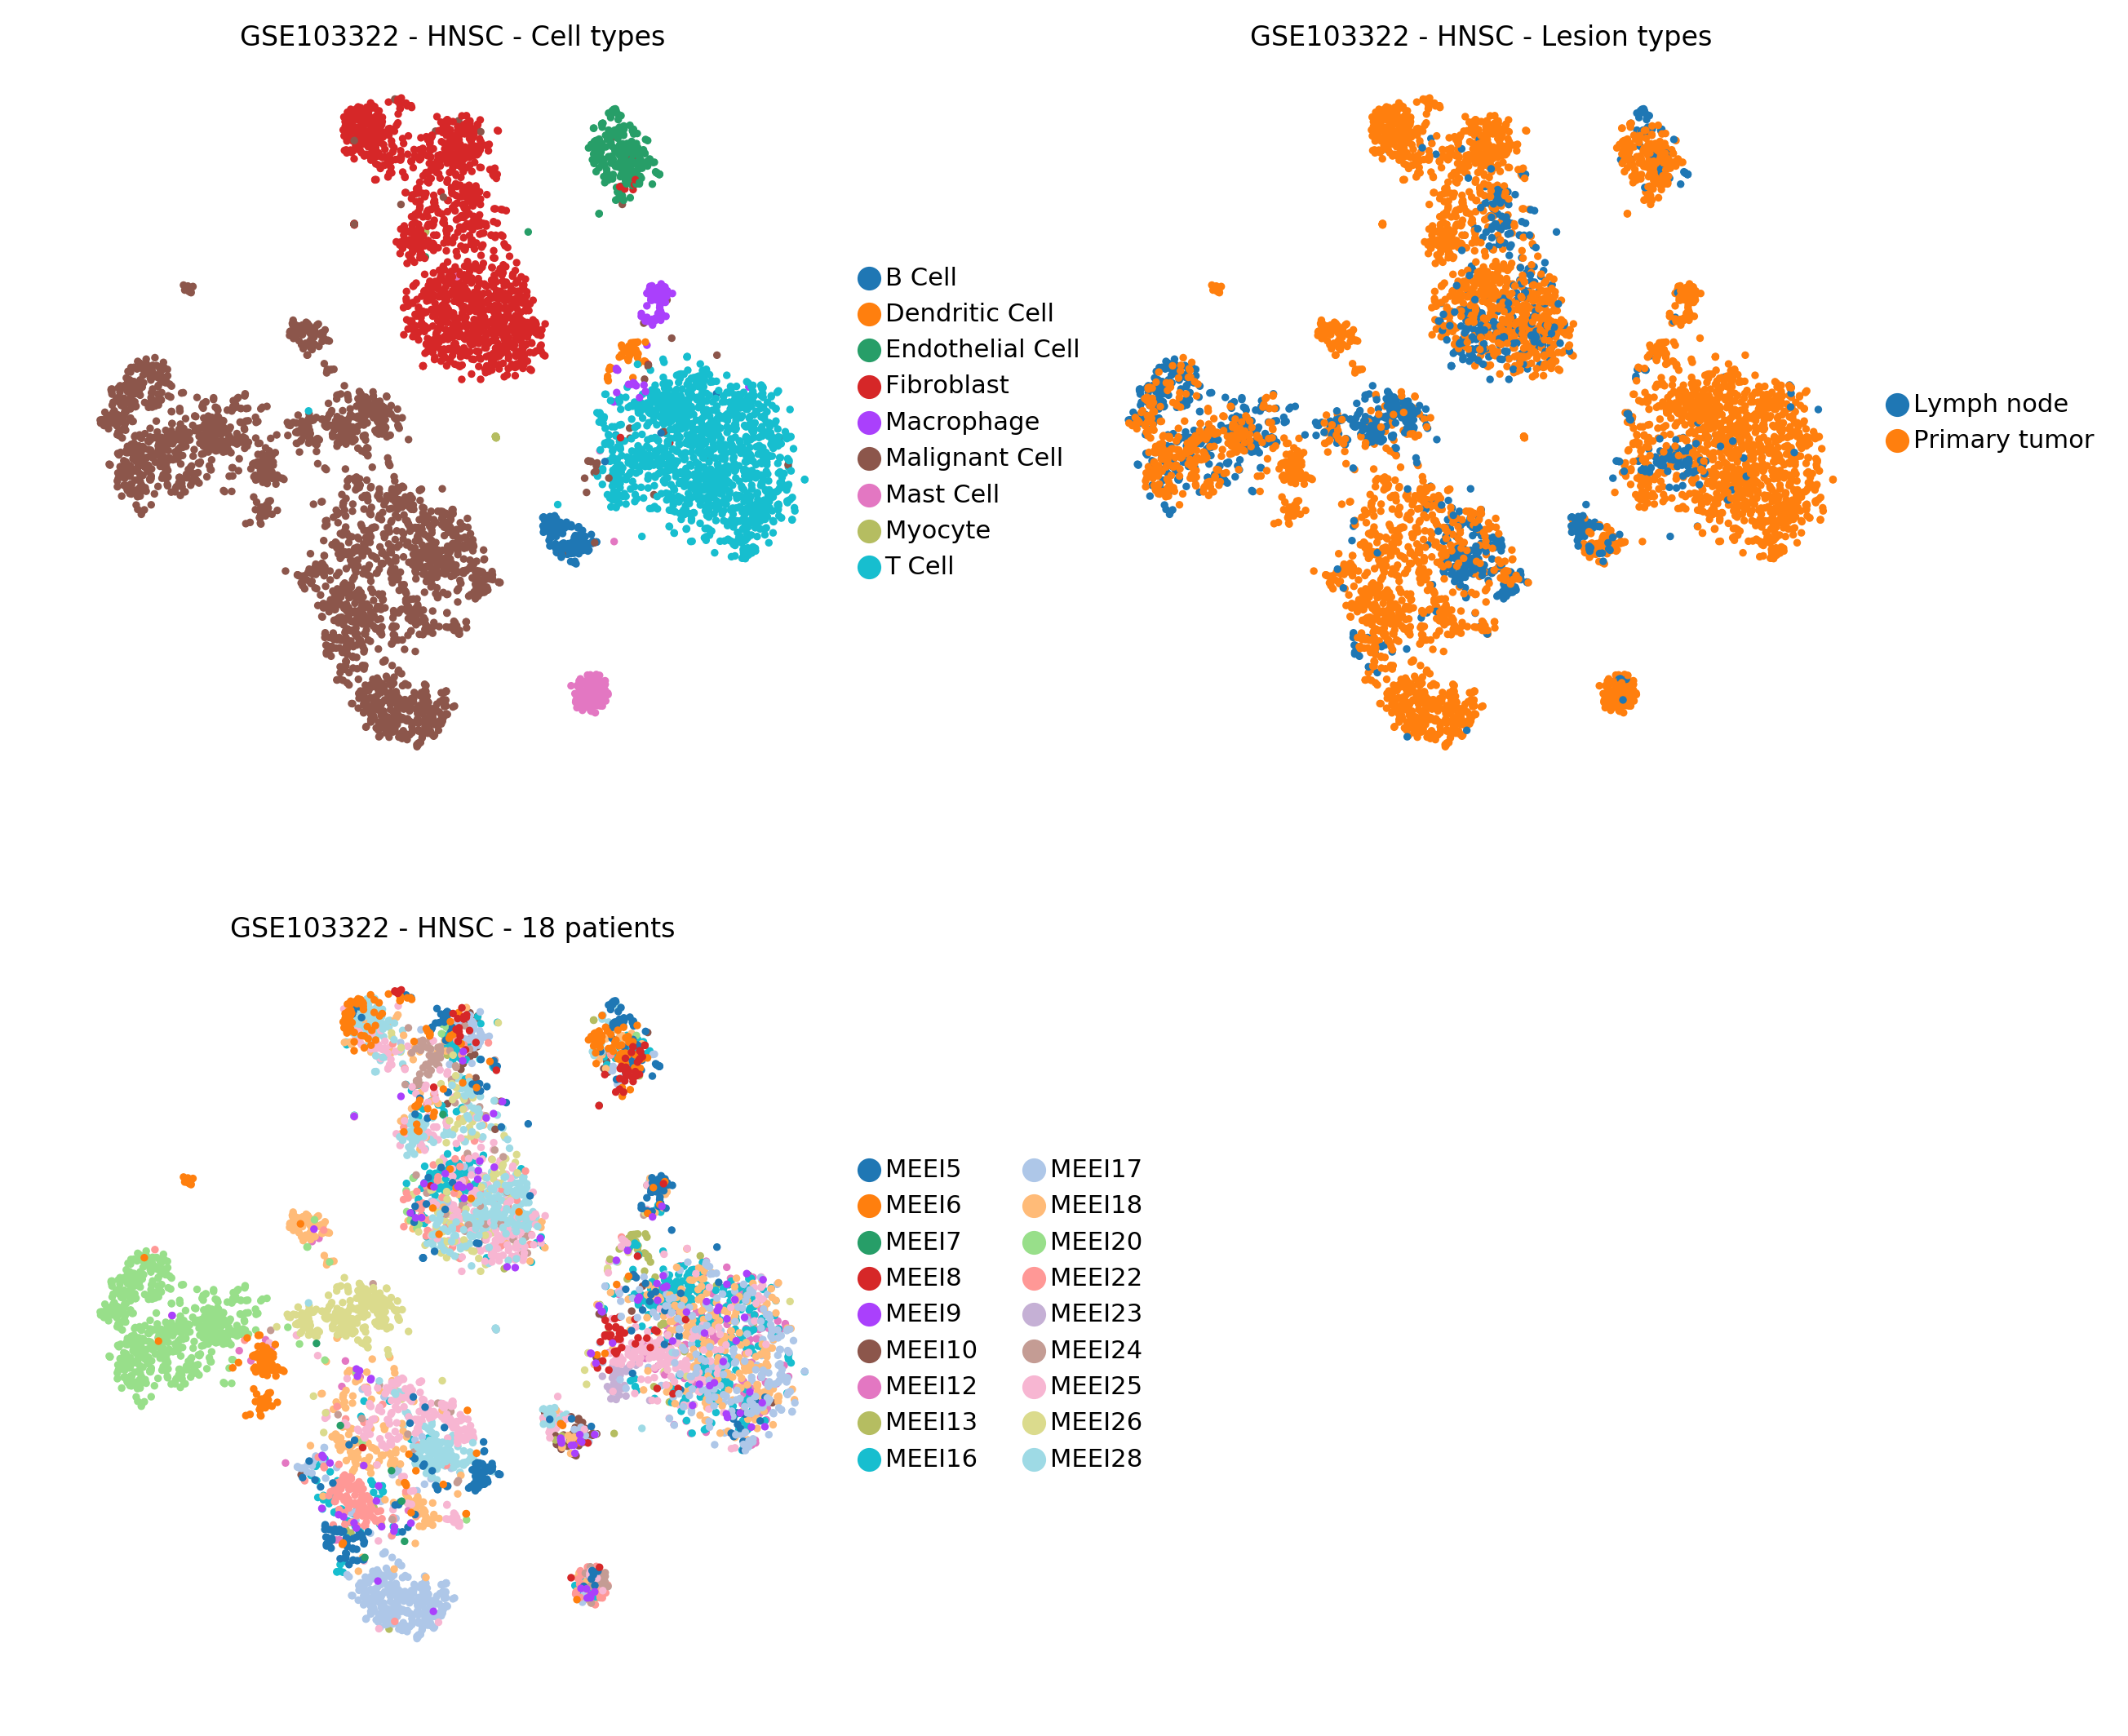

In [60]:
sc.set_figure_params(frameon=False, dpi=150, fontsize=8)
sc.pl.tsne(adata, color=['cell_type', 'lesion_type','patient_id'], 
           title=['GSE103322 - HNSC - Cell types', 'GSE103322 - HNSC - Lesion types',
                 'GSE103322 - HNSC - {} patients'.format(len(adata.obs.patient_id.unique()))], ncols=2)

In [61]:
export2loom(adata.to_df(), regulons, LOOM_FNAME,
            cell_annotations=adata.obs['cell_type'].to_dict(),
            embeddings=OrderedDict([('AUCell + tSNE', embedding_aucell_tsne), ('PCA + tSNE', embedding_pca_tsne)]),
            auc_mtx = auc_mtx,
            tree_structure=(),
            title='HNSC_GSE103322',
            nomenclature="HGNC", 
            compress=True)

Regulon name does not seem to be compatible with SCOPE. It should include a space to allow selection of the TF. 
Please run: 
 regulons = [r.rename(r.name.replace('(+)',' ('+str(len(r))+'g)')) for r in regulons] 
or:
 regulons = [r.rename(r.name.replace('(',' (')) for r in regulons]


# E-MTAB-6149/E-MTAB-6653 - Lung Squamous Cell Carcinoma and Lung Adenocarcinoma (LUSC & LUAD)

_Publication:_

Phenotype molding of stromal cells in the lung tumor microenvironment.

Diether Lambrechts, Els Wauters, Bram Boeckx, Sara Aibar, David Nittner, Oliver Burton, Ayse Bassez, Herbert Decaluwé, Andreas Pircher, Kathleen Van den Eynde, Birgit Weynand, Erik Verbeken, Paul De Leyn, Adrian Liston, Johan Vansteenkiste, Peter Carmeliet, Stein Aerts, Bernard Thienpont

Cancer cells are embedded in the tumor microenvironment (TME), a complex ecosystem of stromal cells. Here, we present a 52,698-cell catalog of the TME transcriptome in human lung tumors at single-cell resolution, validated in independent samples where 40,250 additional cells were sequenced. By comparing with matching non-malignant lung samples, we reveal a highly complex TME that profoundly molds stromal cells. We identify 52 stromal cell subtypes, including novel subpopulations in cell types hitherto considered to be homogeneous, as well as transcription factors underlying their heterogeneity. For instance, we discover fibroblasts expressing different collagen sets, endothelial cells downregulating immune cell homing and genes coregulated with established immune checkpoint transcripts and correlating with T-cell activity. By assessing marker genes for these cell subtypes in bulk RNA-sequencing data from 1,572 patients, we illustrate how these correlate with survival, while immunohistochemistry for selected markers validates them as separate cellular entities in an independent series of lung tumors. Hence, in providing a comprehensive catalog of stromal cells types and by characterizing their phenotype and co-optive behavior, this resource provides deeper insights into lung cancer biology that will be helpful in advancing lung cancer diagnosis and therapy.

Nature Medicine 2018

https://dx.doi.org/10.1038/s41591-018-0096-5

_Data set acquisition:_

https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-6149/

https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-6653/

__TODO:__ What is the unit of expression?

In [62]:
GEO_ACCESSION = "E-MTAB-6149_6653"
BASE_FOLDER = "/home/bramvds/Documents/datasets"
DATASET_FOLDER = os.path.join(BASE_FOLDER, GEO_ACCESSION)

MTX_FNAME = os.path.join(DATASET_FOLDER, '{}.tpm.csv'.format(GEO_ACCESSION))

ANNOT_FNAME = os.path.join(DATASET_FOLDER, '{}.annotations.csv'.format(GEO_ACCESSION))
METADATA_FNAME = os.path.join(DATASET_FOLDER, '{}.metadata.csv'.format(GEO_ACCESSION))
SCORES_MTX_FNAME = os.path.join(DATASET_FOLDER, '{}.scores.csv'.format(GEO_ACCESSION))
ANNDATA_FNAME = os.path.join(DATASET_FOLDER, '{}.h5ad'.format(GEO_ACCESSION))

AUCELL_MTX_FNAME = '/home/bramvds/Documents/scenic_resources/{}.auc.csv'.format(GEO_ACCESSION)
REGULONS_DAT_FNAME = '/home/bramvds/Documents/scenic_resources/{}.regulons.dat'.format(GEO_ACCESSION)

LOOM_FNAME = os.path.join(DATASET_FOLDER, 'LUSC_LUAD_{}.loom'.format(GEO_ACCESSION))

__METADATA CLEANING__

In [63]:
annotations = pd.read_csv(os.path.join(DATASET_FOLDER, 'b_thienpont.clusters.txt'), sep=' ', index_col=0)
annotations['lesion_type'] = ['LC' if row['CellFromTumor'] else 'NL' for _, row in annotations.iterrows()]

In [64]:
annotations = annotations[['cell', 'CellType', 'Sample', 'Patientnumber', 'lesion_type']].rename(columns={
    'cell': 'cell_id',
    'Sample': 'sample_id',
    'Patientnumber': 'patient_id',
    'CellType': 'cell_type'}).set_index('cell_id')

In [65]:
annotations['cell_type'] = annotations.cell_type.replace({'T_cell': 'T cell',
                               'B_cell': 'B cell',
                               'Fibro': 'Fibroblast',
                               'tumor': 'Malignant cell',
                               'Epi': 'Epithelial cell', 
                               'EC': 'Endothelial cell',
                               'Alveolar': 'Alveolar cell',
                               'Myeloid': 'Meyloid cell'})
annotations['patient_id'] = annotations['patient_id'].map(str)
annotations['sample_id'] = annotations['sample_id'].map(str)

In [66]:
annotations.to_csv(ANNOT_FNAME, sep=',')

__EXPRESSION MATRIX__

In [67]:
mtx = pd.read_csv(os.path.join(DATASET_FOLDER, 'E-MTAB-6149_6653.expr.tsv'), sep='\t', index_col=0)

__ANNDATA__

In [68]:
adata = sc.AnnData(X=mtx.T.sort_index())
adata.obs = annotations.sort_index()
adata.var_names_make_unique()
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.raw = adata #Store non-log transformed data as raw. This data can be used via the use_raw parameters available for many functions.
sc.pp.log1p(adata)
adata

AnnData object with n_obs × n_vars = 51628 × 9919 
    obs: 'cell_type', 'sample_id', 'patient_id', 'lesion_type', 'n_genes'
    var: 'n_cells'

In [69]:
adata.write_h5ad(ANNDATA_FNAME)

... storing 'cell_type' as categorical
... storing 'sample_id' as categorical
... storing 'patient_id' as categorical
... storing 'lesion_type' as categorical


__ADD DIMENSIONAL REDUCTIONS__

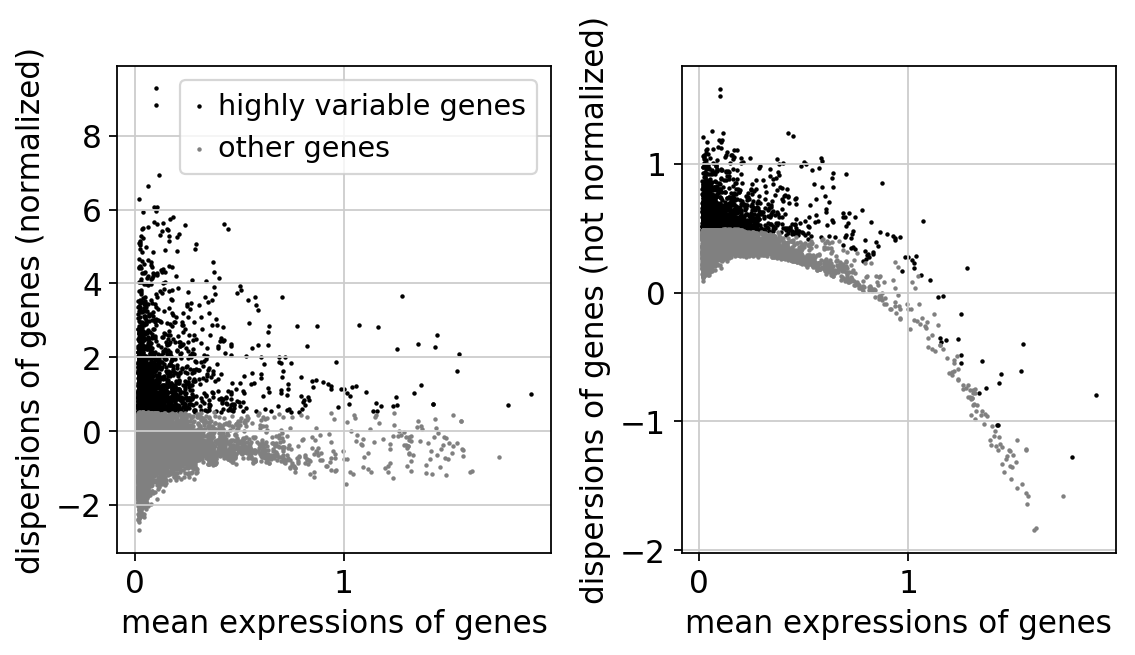

In [70]:
sc.set_figure_params()
sc.pp.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata)

In [71]:
adata.var['highly_variable']['HLA-G']

False

In [2]:
sc.tl.pca(adata, svd_solver='arpack')

NameError: name 'sc' is not defined

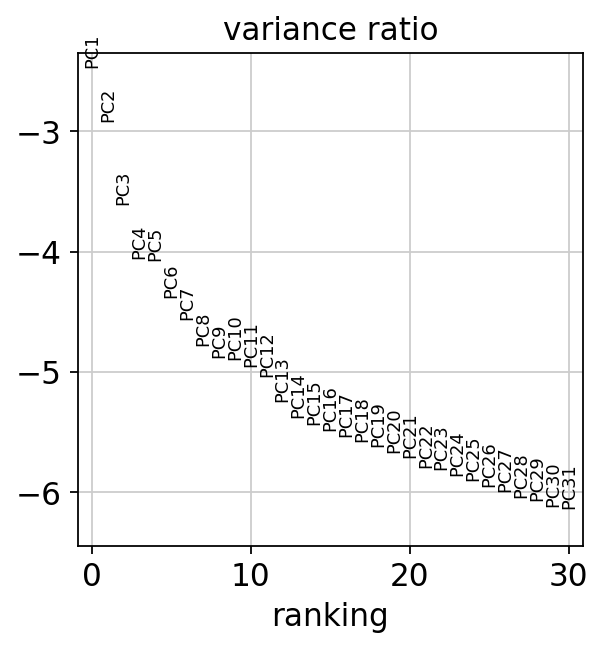

In [73]:
sc.pl.pca_variance_ratio(adata, log=True)

In [74]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.tsne(adata)
sc.tl.louvain(adata)

In [75]:
adata.write_h5ad(ANNDATA_FNAME)

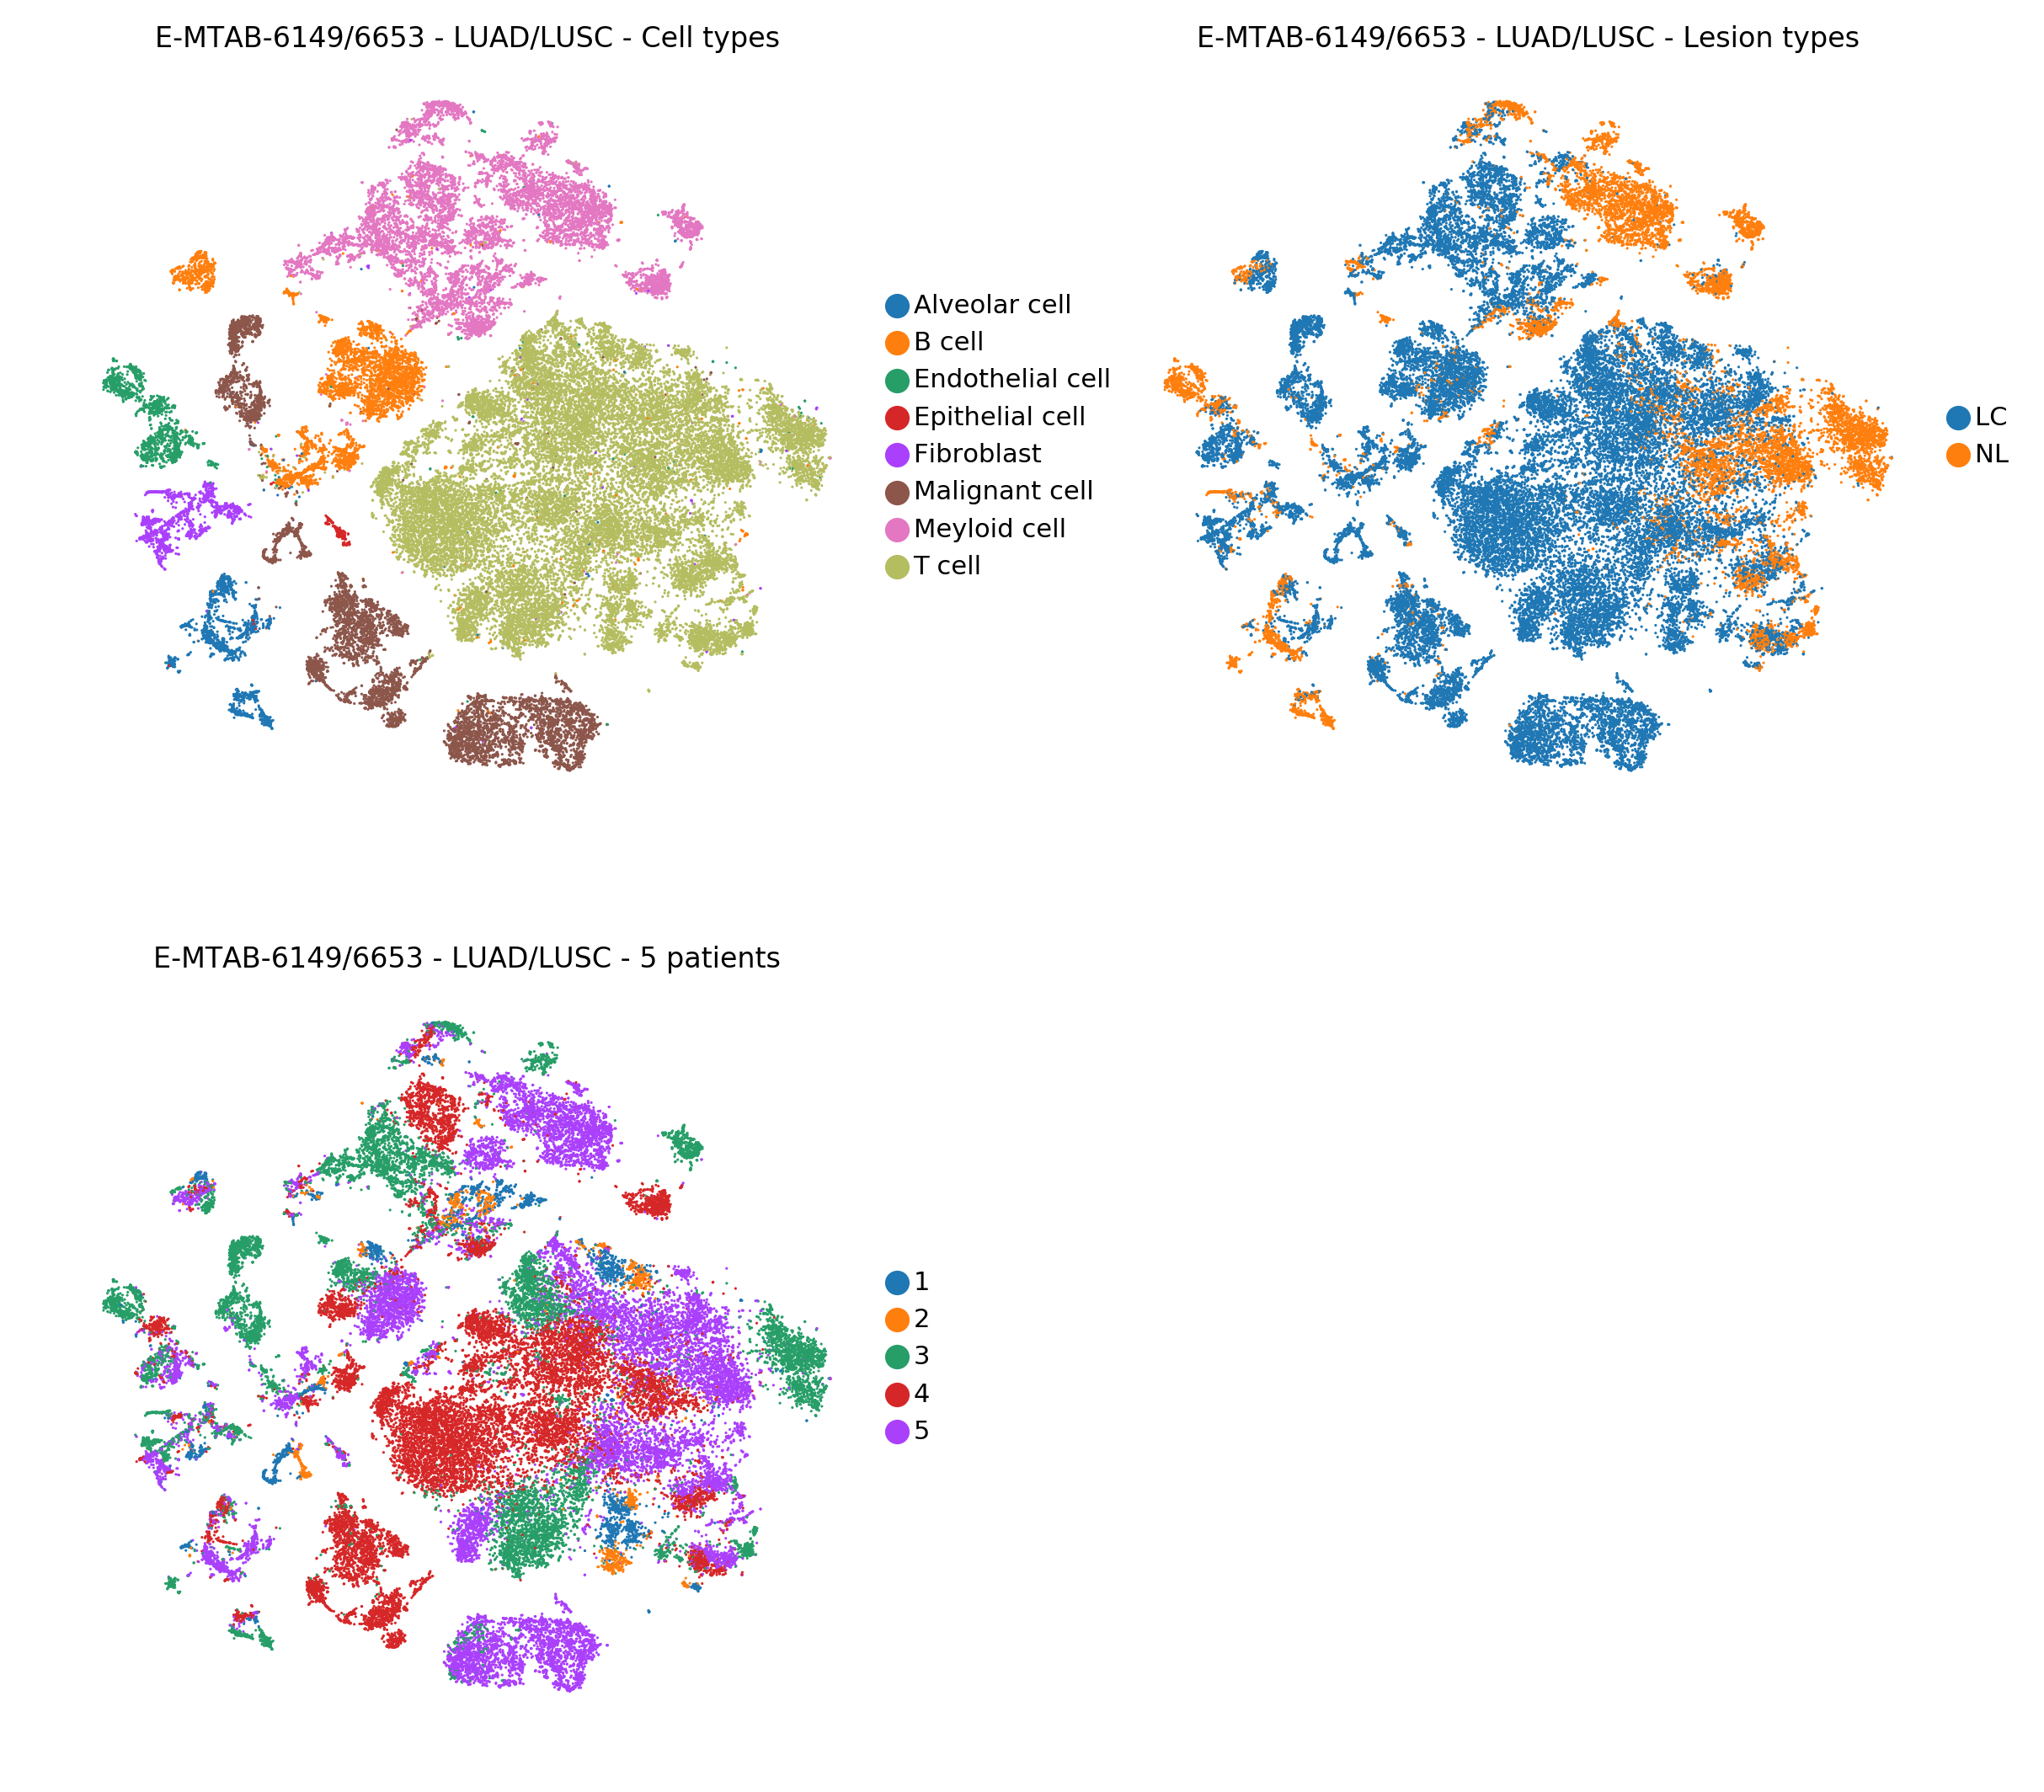

In [76]:
sc.set_figure_params(frameon=False, dpi=150, fontsize=8)
sc.pl.tsne(adata, color=['cell_type', 'lesion_type', 'patient_id'], 
           title=['E-MTAB-6149/6653 - LUAD/LUSC - Cell types', 
                  'E-MTAB-6149/6653 - LUAD/LUSC - Lesion types', 
                  'E-MTAB-6149/6653 - LUAD/LUSC - {} patients'.format(len(adata.obs.patient_id.unique()))], ncols=2)

In [77]:
embedding_pca_tsne = pd.DataFrame(adata.obsm['X_tsne'], columns=[['_X', '_Y']], index=adata.obs_names)

In [78]:
import pickle

auc_mtx = pd.read_csv(AUCELL_MTX_FNAME, index_col=0)
with open(REGULONS_DAT_FNAME, 'rb') as f:
    regulons = pickle.load(f)
add_scenic_metadata(adata, auc_mtx, regulons)
adata.write_h5ad(ANNDATA_FNAME)

In [79]:
sc.tl.tsne(adata, use_rep='X_aucell')

In [80]:
embedding_aucell_tsne = pd.DataFrame(adata.obsm['X_tsne'], columns=[['_X', '_Y']], index=adata.obs_names)

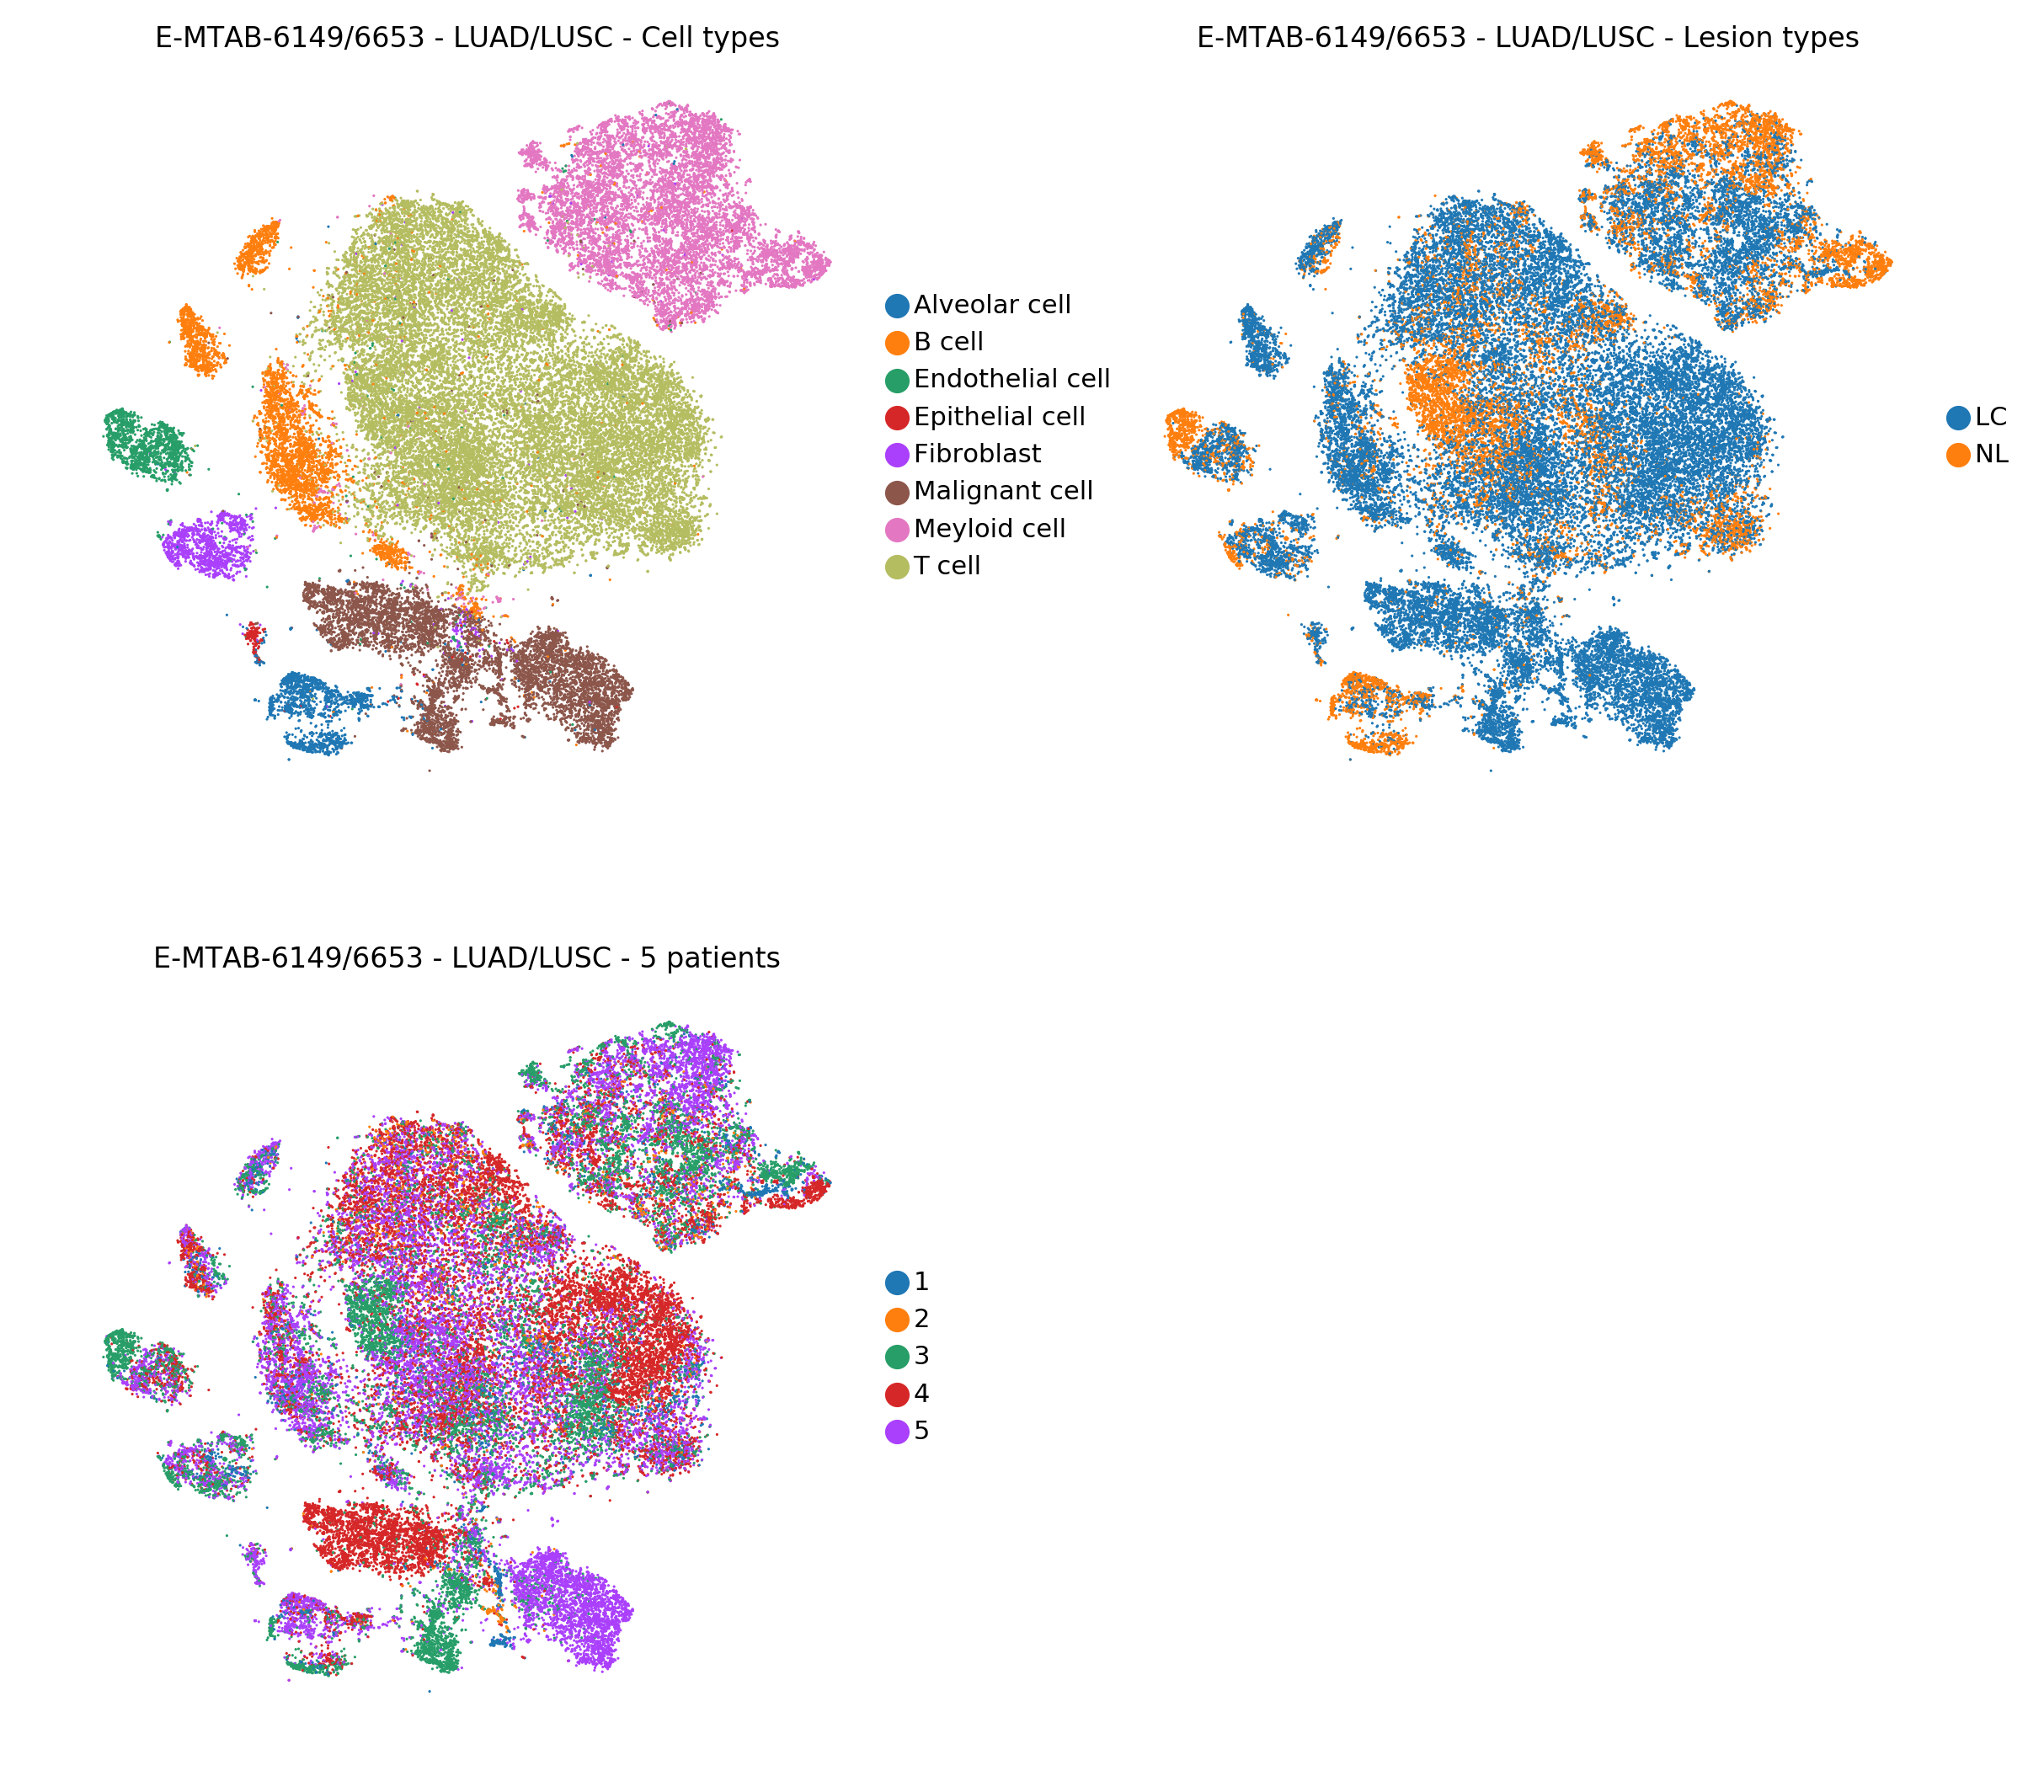

In [81]:
sc.set_figure_params(frameon=False, dpi=150, fontsize=8)
sc.pl.tsne(adata, color=['cell_type', 'lesion_type', 'patient_id'], 
           title=['E-MTAB-6149/6653 - LUAD/LUSC - Cell types', 
                  'E-MTAB-6149/6653 - LUAD/LUSC - Lesion types', 
                  'E-MTAB-6149/6653 - LUAD/LUSC - {} patients'.format(len(adata.obs.patient_id.unique()))], ncols=2)

In [82]:
export2loom(adata.to_df(), regulons, LOOM_FNAME,
            cell_annotations=adata.obs['cell_type'].to_dict(),
            embeddings=OrderedDict([('AUCell + tSNE', embedding_aucell_tsne), ('PCA + tSNE', embedding_pca_tsne)]),
            auc_mtx = auc_mtx,
            tree_structure=(),
            title='LUSC/LUAD_E-MTAB-6149_6653',
            nomenclature="HGNC", 
            compress=True)

Regulon name does not seem to be compatible with SCOPE. It should include a space to allow selection of the TF. 
Please run: 
 regulons = [r.rename(r.name.replace('(+)',' ('+str(len(r))+'g)')) for r in regulons] 
or:
 regulons = [r.rename(r.name.replace('(',' (')) for r in regulons]
